1. Data Collection and Preprocessing
Data Sources: Gather historical sales data, order data, product data, and customer behavior data from Shopee Singapore's datasets. Relevant features may include order volumes, product categories, timestamps, stock levels, customer demographics, and historical prices.
Data Cleaning: Address any missing values, duplicates, and inconsistencies in the data to ensure a robust foundation for modeling.
Feature Engineering: Create new features such as seasonality indicators, promotional activity markers, and product popularity scores based on sales frequency and revenue generated.

2. Demand Forecasting Models
Time Series Forecasting: Apply models like ARIMA, Prophet, or LSTM (if using deep learning) to predict future sales demand for each product category. Incorporate seasonality (e.g., holiday spikes) and trends in your models to increase accuracy.
Machine Learning Regression Models: Use regression models (e.g., Random Forest Regressor, XGBoost) with features such as historical sales, price changes, promotions, and external factors (e.g., macroeconomic indicators, competitor prices) to forecast demand.
Evaluation: Assess the model's performance using metrics like Mean Absolute Error (MAE) or Root Mean Square Error (RMSE). Fine-tune the models through cross-validation and hyperparameter optimization.

3. Inventory Optimization Techniques
Economic Order Quantity (EOQ): Calculate EOQ for products to determine the optimal order quantity that minimizes both holding and ordering costs.
Safety Stock Analysis: Calculate safety stock levels using demand variability and lead time statistics to ensure product availability even during demand spikes or supplier delays.
Reorder Point Calculation: Use the formula:
Reorder Point
=
Lead Time Demand
+
Safety Stock
Reorder Point=Lead Time Demand+Safety Stock
where lead time demand is the average sales volume multiplied by lead time.
ABC Analysis: Classify products based on sales volume and value (A for high value, B for moderate, C for low value). Apply different inventory management strategies for each category (e.g., high safety stock for A, lower for C).

4. Optimization Algorithms for Inventory Levels
Linear Programming: Formulate a linear programming problem that minimizes the total cost (holding, ordering, and shortage costs) while meeting demand constraints. Python libraries like SciPy or PuLP can be used for this.
Reinforcement Learning: Implement reinforcement learning models (e.g., Q-Learning) to optimize reorder policies dynamically, especially for fast-moving products. These models learn from data and continuously improve as new sales data comes in.

5. Performance Monitoring and Adjustment
Dashboard Implementation: Develop dashboards using tools like Tableau or Power BI to monitor key metrics (e.g., stock levels, stockout rates, inventory turnover ratio) and adjust strategies in real-time.
Scenario Analysis: Simulate different scenarios (e.g., sudden demand surges, supplier delays) using Monte Carlo simulations to ensure robustness and responsiveness in your inventory system.

6. Leveraging Data-Driven Insights
Product Segmentation: Identify slow-moving, high-demand, and high-margin products to create tailored inventory strategies.
Price Sensitivity Analysis: Analyze the relationship between pricing and demand to optimize prices that reduce excess stock while boosting sales.
Customer Behavior Analysis: Use customer data to understand buying patterns and personalize inventory levels based on high-value customer preferences and product loyalty scores.

In [150]:
import sys
# !{sys.executable} -m pip install --upgrade numpy pandas matplotlib scikit-learn

In [178]:
import pandas as pd
import numpy as np

# Load data
orders_df = pd.read_csv('../Cleaned_Datasets/orders_generated.csv')
products_df = pd.read_csv('../Cleaned_Datasets/products_cleaned.csv')
customers_df = pd.read_csv('../Cleaned_Datasets/customer_SG_only.csv')

# Initialize restock thresholds and percentages in products_df
np.random.seed(0)
products_df['restock_threshold'] = np.random.randint(5, 15, size=len(products_df))
products_df['restock_percentage'] = np.random.uniform(0.15, 0.3, size=len(products_df))

def randomize_missing_ratings(df, column='item_rating', min_rating=3.0, max_rating=5.0):
    # Fill missing ratings with random values within the specified range
    no_rating = 'No ratings yet'
    df.loc[df[column] == no_rating, column] = np.random.uniform(min_rating, max_rating, size=df[df[column] == no_rating].shape[0])
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df.loc[pd.isnull(df[column]), column] = np.random.uniform(min_rating, max_rating, size=df[pd.isnull(df[column])].shape[0])
    return df

products_df = randomize_missing_ratings(products_df)

products_df['seller_rating'] = products_df.groupby('seller_name')['item_rating'].transform('mean')

def generate_seller_response_time(df):

    # The function response_time_by_rating takes in the seller_rating and outputs a random number from a set range of values for
    # that specific seller rating
    def response_time_by_rating(seller_rating):
        if seller_rating >= 5.0:
            return np.random.uniform(0.01, 0.5)
        elif seller_rating >= 4.9:
            return np.random.uniform(0.05, 1)
        elif seller_rating >= 4.8:
            return np.random.uniform(0.3, 2)
        elif seller_rating >= 4.7:
            return np.random.uniform(0.5, 4)
        elif seller_rating >= 4.6:
            return np.random.uniform(0.8, 8)
        elif seller_rating >= 4.5:
            return np.random.uniform(1, 16)
        elif seller_rating >= 4.4:
            return np.random.uniform(1.2, 32)
        elif seller_rating >= 4.3:
            return np.random.uniform(2.4, 35)
        elif seller_rating >= 4.2:
            return np.random.uniform(4.8, 38)
        elif seller_rating >= 4.1:
            return np.random.uniform(5, 40)
        elif seller_rating >= 4.0:
            return np.random.uniform(6, 50)
        else:
            return np.random.uniform(10, 80)

    # Apply the above function 'response_time_by_rating' to the dataset
    df['seller_response_time'] = df['seller_rating'].apply(response_time_by_rating)

    # Introduce noise and outliers/anomalies
    for seller in df['seller_name'].unique():
        # we set a 5% chance for each seller to be an outlier
        if np.random.rand() < 0.05:
            df.loc[df['seller_name'] == seller, 'seller_response_time'] = df.loc[
                df['seller_name'] == seller, 'seller_response_time'
            ].apply(lambda x: x * np.random.uniform(0.2, 10))  # Multiply response time by a random factor

    return df

# We apply the above 'generate_seller_response_time' function to our dataset
products_df = generate_seller_response_time(products_df)

customers_columns = ['last_open_day', 'last_login_day', 'last_checkout_day', 'open_count_last_10_days',
    'open_count_last_30_days', 'open_count_last_60_days', 'login_count_last_10_days', 'login_count_last_30_days',
    'login_count_last_60_days', 'checkout_count_last_10_days', 'checkout_count_last_30_days',
    'checkout_count_last_60_days', 'checkout_count_last_1_year',
    'age']

for col in customers_columns:
    customers_df[col] = pd.to_numeric(customers_df[col], errors='coerce')

# Define cost and lead time ranges by `main_category` and `Ships_From`
production_cost_percentages = {
    'Health & Beauty': (0.05, 0.1), 'Men Clothes': (0.08, 0.15), 'Women Clothes': (0.08, 0.15),
    'Mobile & Accessories': (0.1, 0.2), 'Baby & Toys': (0.07, 0.12), 'Home & Living': (0.08, 0.15),
    'Groceries & Pets': (0.05, 0.1), 'Home Appliances': (0.1, 0.25), 'Automotive': (0.1, 0.25),
    'Sports & Outdoor': (0.1, 0.2), 'Women\'s Bags': (0.08, 0.18), 'Watches': (0.1, 0.2),
    'Men\'s Bags & Wallets': (0.08, 0.15), 'Cameras & Drones': (0.15, 0.3), 'Women Shoes': (0.08, 0.2),
    'Muslim Fashion': (0.07, 0.15), 'Fashion Accessories': (0.05, 0.1), 'Computer & Accessories': (0.1, 0.25),
    'Games, Books & Hobbies': (0.08, 0.12), 'Men Shoes': (0.08, 0.15), 'Travel & Luggage': (0.1, 0.2),
    'Gaming & Consoles': (0.12, 0.25), 'Tickets & Vouchers': (0.05, 0.08), 'Others': (0.08, 0.15)
}

holding_cost_percentage_range = (0.02, 0.05)  # Holding cost as a random percentage of price_actual

lead_time_ranges = {
    "Singapore": (1.0, 3.0), "Malaysia": (3.0, 8.0), "Indonesia": (5.0, 12.0), "Thailand": (5.0, 12.0),
    "Vietnam": (7.0, 15.0), "China": (10.0, 25.0), "Taiwan": (8.0, 20.0), "South Korea": (7.0, 18.0)
}

# Calculate cost_to_produce as a random percentage of `price_actual` based on `main_category`
products_df['cost_to_produce'] = products_df.apply(
    lambda row: row['price_actual'] * np.random.uniform(
        *production_cost_percentages.get(row['main_category'], (0.1, 0.2))
    ), axis=1
)

# Calculate holding_cost as a random percentage of `price_actual`
products_df['holding_cost'] = products_df['price_actual'] * np.random.uniform(*holding_cost_percentage_range)

# Calculate lead_time based on `Ships_From` with four decimal places
products_df['lead_time'] = products_df['Ships_From'].apply(
    lambda x: round(np.random.uniform(*lead_time_ranges.get(x, (5.0, 20.0))), 4)
)

# Merge dataframes and convert 'order_time' to datetime
orders_products_df = pd.merge(orders_df, products_df, on='product_id', how='left')
merged_df = pd.merge(orders_products_df, customers_df, on='customer_id', how='left')
merged_df['order_time'] = pd.to_datetime(merged_df['order_time'], errors='coerce')
merged_df.dropna(subset=['order_time'], inplace=True)

# Sort by order time for sequential processing
merged_df.sort_values(by='order_time', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Add a 'date' column and extract day-of-week, month, and weekend flag for seasonality
merged_df['date'] = merged_df['order_time'].dt.date
merged_df['day_of_week'] = merged_df['order_time'].dt.dayofweek
merged_df['is_weekend'] = merged_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
merged_df['month'] = merged_df['order_time'].dt.month

# Initialize discount and engagement features
merged_df['is_discount'] = merged_df['price_actual'] < merged_df['price_ori']
merged_df['discount_percentage'] = np.where(
    merged_df['is_discount'],
    ((merged_df['price_ori'] - merged_df['price_actual']) / merged_df['price_ori']) * 100,
    0
)

def generate_delivery_time(df):

    # Function that takes in the item_rating and outputs a random number from a set range corresponding to that specific item's rating
    # For example, an item rating of 5 stars would mean that the item takes about 1-3 days to be delivered to the customer
    def delivery_time_by_rating(item_rating):
        if item_rating >= 5.0:
            return np.random.uniform(1, 3)
        elif item_rating >= 4.9:
            return np.random.uniform(1, 3.5)
        elif item_rating >= 4.8:
            return np.random.uniform(1.5, 4)
        elif item_rating >= 4.7:
            return np.random.uniform(1.5, 4.5)
        elif item_rating >= 4.6:
            return np.random.uniform(2, 5)
        elif item_rating >= 4.5:
            return np.random.uniform(2, 5.5)
        elif item_rating >= 4.4:
            return np.random.uniform(2.5, 6)
        elif item_rating >= 4.3:
            return np.random.uniform(2.5, 6.5)
        elif item_rating >= 4.2:
            return np.random.uniform(3, 7)
        elif item_rating >= 4.1:
            return np.random.uniform(3, 7.5)
        elif item_rating >= 4.0:
            return np.random.uniform(3.5, 8)
        else:
            return np.random.uniform(7, 21)

    # We apply the above function 'delivery_time_by_rating' to each row of our dataset
    df['delivery_time'] = df['item_rating'].apply(delivery_time_by_rating)


    for seller in df['seller_name'].unique():
        # we set a 5% chance for each seller to be an outlier
        if np.random.rand() < 0.05:
            df.loc[df['seller_name'] == seller, 'delivery_time'] = df.loc[
                df['seller_name'] == seller, 'delivery_time'
            ].apply(lambda x: x * np.random.uniform(0.5, 3))  # Multiply delivery time by a random factor

    # Adding additional delivery time in days based on ship_from column
    def add_delivery_time_by_ship_from(ship_from):
        if ship_from == 'China':
            return np.random.uniform(7, 14)
        elif ship_from == 'Indonesia':
            return np.random.uniform(2, 5)
        elif ship_from == 'Malaysia':
            return np.random.uniform(1, 3)
        elif ship_from == 'South Korea':
            return np.random.uniform(5, 10)
        elif ship_from == 'Taiwan':
            return np.random.uniform(5, 9)
        elif ship_from == 'Thailand':
            return np.random.uniform(3, 6)
        elif ship_from == 'Vietnam':
            return np.random.uniform(4, 7)

    # Applying the above functions to the dataset
    df['additional_delivery_time'] = df['Ships_From'].apply(add_delivery_time_by_ship_from)
    df['delivery_time'] = df['delivery_time'] + df['additional_delivery_time']

    return df

# We apply the above 'generate_delivery_time' function to our 2 datasets
merged_df = generate_delivery_time(merged_df)

# Ensure numerical columns are converted to numeric types
numeric_columns = [
    'price_ori', 'price_actual', 'item_rating', 'total_rating', 'seller_rating', 'total_sold', 'favorite', 'Stock',
    'restock_threshold', 'restock_percentage', 'cost_to_produce', 'holding_cost', 'lead_time', 'delivery_time',
    'last_open_day', 'last_login_day', 'last_checkout_day', 'open_count_last_10_days',
    'open_count_last_30_days', 'open_count_last_60_days', 'login_count_last_10_days', 'login_count_last_30_days',
    'login_count_last_60_days', 'checkout_count_last_10_days', 'checkout_count_last_30_days',
    'checkout_count_last_60_days', 'checkout_count_last_1_year',
    'age', 'discount_percentage'
]

for col in numeric_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Initialize running cumulative totals for each product
product_cumulative = {
    product_id: {
        'total_sold': row['total_sold'],
        'total_rating': row['total_rating'],
        'Stock': row['Stock']
    }
    for product_id, row in products_df.set_index('product_id').iterrows()
}

customer_cumulative = {
    customer_id: {
        'last_open_day': row['last_open_day'],
        'last_login_day': row['last_login_day'],
        'last_checkout_day': row['last_checkout_day'],

        'open_count_last_10_days': row['open_count_last_10_days'],
        'open_count_last_30_days': row['open_count_last_30_days'],
        'open_count_last_60_days': row['open_count_last_60_days'],

        'login_count_last_10_days': row['login_count_last_10_days'],
        'login_count_last_30_days': row['login_count_last_30_days'],
        'login_count_last_60_days': row['login_count_last_60_days'],

        'checkout_count_last_10_days': row['checkout_count_last_10_days'],
        'checkout_count_last_30_days': row['checkout_count_last_30_days'],
        'checkout_count_last_60_days': row['checkout_count_last_60_days'],
        'checkout_count_last_1_year': row['checkout_count_last_1_year']
    }
    for customer_id, row in customers_df.set_index('customer_id').iterrows()
}


In [152]:
# Update cumulative values for each row without looping for daily sales
for i, row in merged_df.iterrows():
    product_id = row['product_id']
    customer_id = row['customer_id']


    # Update cumulative total_sold and total_rating
    product_cumulative[product_id]['total_sold'] += 1
    product_cumulative[product_id]['total_rating'] += 1

    # Update Stock and check if restocking is needed
    product_cumulative[product_id]['Stock'] -= 1
    if product_cumulative[product_id]['Stock'] < row['restock_threshold']:
        product_cumulative[product_id]['Stock'] += int(product_cumulative[product_id]['Stock'] * row['restock_percentage'])


    customer_cumulative[customer_id]['last_login_day'] = 1
    customer_cumulative[customer_id]['last_checkout_day'] = 1

    customer_cumulative[customer_id]['login_count_last_10_days'] += 1
    customer_cumulative[customer_id]['login_count_last_30_days'] += 1
    customer_cumulative[customer_id]['login_count_last_60_days'] += 1

    customer_cumulative[customer_id]['checkout_count_last_10_days'] += 1
    customer_cumulative[customer_id]['checkout_count_last_30_days'] += 1
    customer_cumulative[customer_id]['checkout_count_last_60_days'] += 1
    customer_cumulative[customer_id]['checkout_count_last_1_year'] += 1

    if row['is_discount'] == True:
        customer_cumulative[customer_id]['last_open_day'] = 1
        customer_cumulative[customer_id]['open_count_last_10_days'] += 1
        customer_cumulative[customer_id]['open_count_last_30_days'] += 1
        customer_cumulative[customer_id]['open_count_last_60_days'] += 1

    # Update the current row in merged_df with cumulative values
    merged_df.at[i, 'total_sold'] = product_cumulative[product_id]['total_sold']
    merged_df.at[i, 'total_rating'] = product_cumulative[product_id]['total_rating']
    merged_df.at[i, 'Stock'] = product_cumulative[product_id]['Stock']

    merged_df.at[i, 'last_login_day'] = customer_cumulative[customer_id]['last_login_day'] 
    merged_df.at[i, 'last_checkout_day'] = customer_cumulative[customer_id]['last_checkout_day'] 

    merged_df.at[i, 'login_count_last_10_days'] = customer_cumulative[customer_id]['login_count_last_10_days'] 
    merged_df.at[i, 'login_count_last_30_days'] = customer_cumulative[customer_id]['login_count_last_30_days'] 
    merged_df.at[i, 'login_count_last_60_days'] = customer_cumulative[customer_id]['login_count_last_60_days'] 

    merged_df.at[i, 'checkout_count_last_10_days'] = customer_cumulative[customer_id]['checkout_count_last_10_days'] 
    merged_df.at[i, 'checkout_count_last_30_days'] = customer_cumulative[customer_id]['checkout_count_last_30_days'] 
    merged_df.at[i, 'checkout_count_last_60_days'] = customer_cumulative[customer_id]['checkout_count_last_60_days'] 
    merged_df.at[i, 'checkout_count_last_1_year'] = customer_cumulative[customer_id]['checkout_count_last_1_year'] 

    merged_df.at[i, 'last_open_day'] = customer_cumulative[customer_id]['last_open_day'] 
    merged_df.at[i, 'open_count_last_10_days'] = customer_cumulative[customer_id]['open_count_last_10_days'] 
    merged_df.at[i, 'open_count_last_30_days'] = customer_cumulative[customer_id]['open_count_last_30_days'] 
    merged_df.at[i, 'open_count_last_60_days'] = customer_cumulative[customer_id]['open_count_last_60_days'] 


In [153]:
daily_aggregated_df = (
    merged_df
    .set_index('order_time')
    .groupby('sub_category')
    .resample('D')
    .agg({
        'price_ori': 'mean',
        'price_actual': 'mean',
        'item_rating': 'mean',
        'total_rating': 'mean',
        'total_sold': 'mean',
        'favorite': 'mean',
        'Stock': 'mean',
        'Ships_From': lambda x: x.mode()[0] if not x.mode().empty else None,  # Mode for non-numeric
        'restock_threshold': 'mean',
        'restock_percentage': 'mean',
        'cost_to_produce': 'mean',
        'holding_cost': 'mean',
        'lead_time': 'mean',
        'last_open_day': 'mean',
        'last_login_day': 'mean',
        'last_checkout_day': 'mean',
        'open_count_last_10_days': 'mean',
        'open_count_last_30_days': 'mean',
        'open_count_last_60_days': 'mean',
        'login_count_last_10_days': 'mean',
        'login_count_last_30_days': 'mean',
        'login_count_last_60_days': 'mean',
        'checkout_count_last_10_days': 'mean',        
        'checkout_count_last_30_days': 'mean',        
        'checkout_count_last_60_days': 'mean',
        'age': 'mean',
        'day_of_week': 'first',  # Use 'first' or other suitable function for non-numeric
        'is_weekend': 'first',
        'month': 'first',
        'is_discount': 'max',  
        'discount_percentage': 'mean',
        'product_id': 'size'
    })
    .rename(columns={
        'price_ori': 'price_ori_avg',
        'price_actual': 'price_actual_avg',
        'item_rating': 'item_rating_avg',
        'total_rating': 'total_rating_avg',
        'total_sold': 'historical_sold_avg',
        'favorite': 'favorite_avg',
        'Stock': 'stock_avg',
        'Ships_From': 'most_from',
        'restock_threshold': 'restock_threshold_avg',
        'restock_percentage': 'restock_percentage_avg',
        'cost_to_produce': 'cost_to_produce_avg',
        'holding_cost': 'holding_cost_avg',
        'lead_time': 'lead_time_avg',
        'last_open_day': 'last_open_day_avg',
        'last_login_day': 'last_login_day_avg',
        'last_checkout_day': 'last_checkout_day_avg',
        'open_count_last_10_days': 'open_count_last_10_days_avg',
        'login_count_last_10_days': 'login_count_last_10_days_avg',
        'checkout_count_last_10_days': 'checkout_count_last_10_days_avg',
        'open_count_last_30_days': 'open_count_last_30_days_avg',
        'login_count_last_30_days': 'login_count_last_30_days_avg',
        'checkout_count_last_30_days': 'checkout_count_last_30_days_avg',
        'open_count_last_60_days': 'open_count_last_60_days_avg',
        'login_count_last_60_days': 'login_count_last_60_days_avg',
        'checkout_count_last_60_days': 'checkout_count_last_60_days_avg',
        'age': 'age_avg',
        'day_of_week': 'day_of_week',
        'is_weekend': 'is_weekend',
        'month': 'month',
        'is_discount': 'any_discount',
        'discount_percentage': 'avg_discount_percentage',
        'product_id': 'daily_sales'
    })
    .reset_index()
)


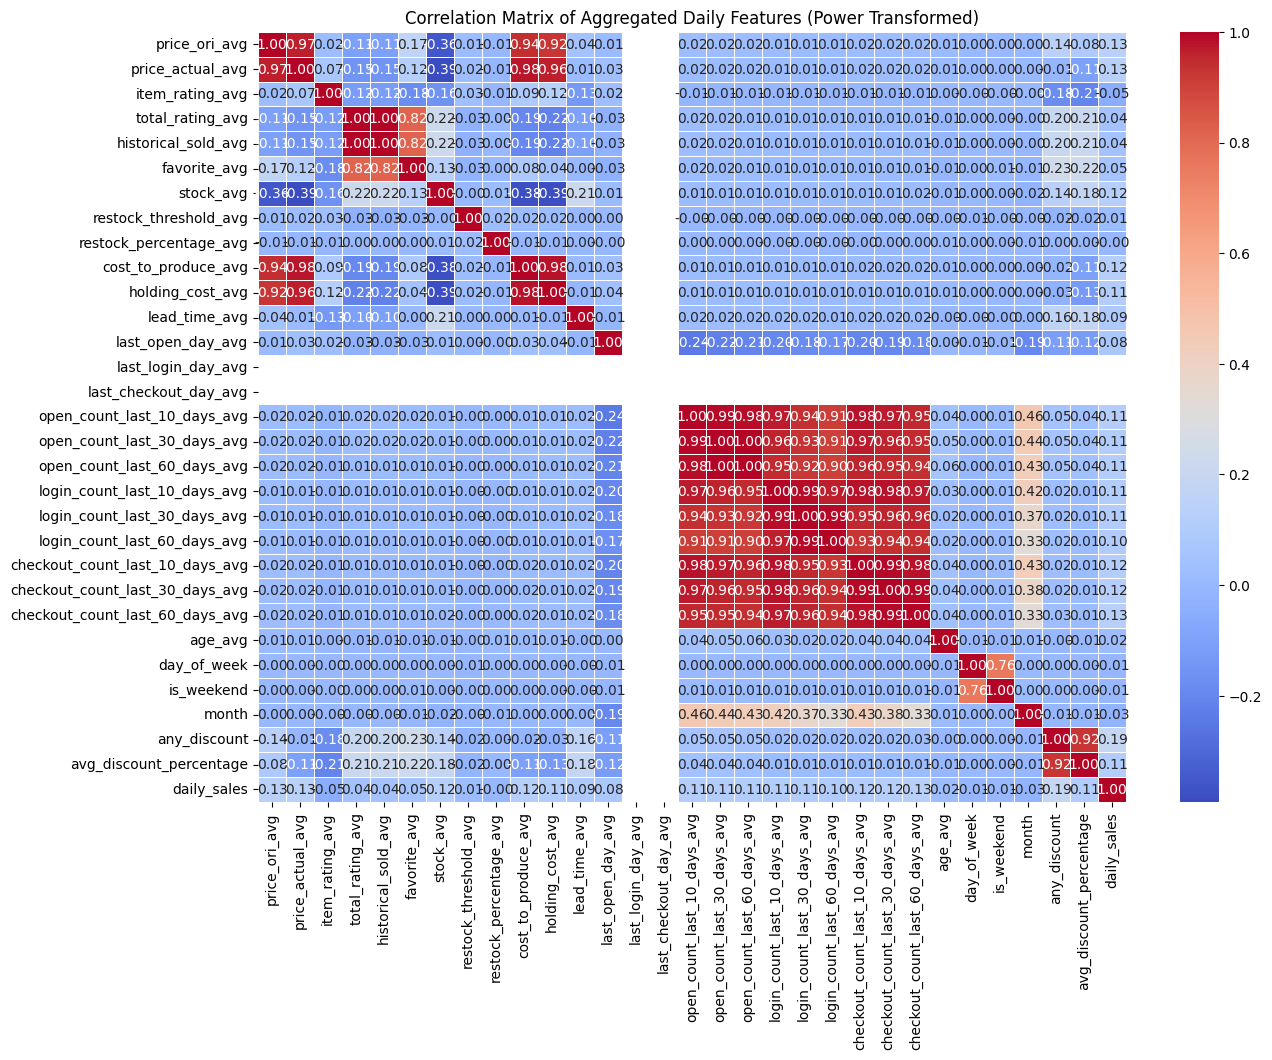

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# Assuming 'daily_aggregated_df' is the dataframe containing the daily aggregated data

# Define the numeric columns to transform
numeric_columns = [
    'price_ori_avg', 'price_actual_avg',
       'item_rating_avg', 'total_rating_avg', 'historical_sold_avg',
       'favorite_avg', 'stock_avg', 'restock_threshold_avg',
       'restock_percentage_avg', 'cost_to_produce_avg', 'holding_cost_avg',
       'lead_time_avg', 'last_open_day_avg', 'last_login_day_avg',
       'last_checkout_day_avg', 'open_count_last_10_days_avg',
       'open_count_last_30_days_avg', 'open_count_last_60_days_avg',
       'login_count_last_10_days_avg', 'login_count_last_30_days_avg',
       'login_count_last_60_days_avg', 'checkout_count_last_10_days_avg',
       'checkout_count_last_30_days_avg', 'checkout_count_last_60_days_avg',
       'age_avg', 'day_of_week', 'is_weekend', 'month', 'any_discount',
       'avg_discount_percentage', 'daily_sales'
]

# Filter to include only numeric columns for transformation
df_numeric = daily_aggregated_df[numeric_columns].copy()

# Apply Power Transformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_transformed = pd.DataFrame(pt.fit_transform(df_numeric), columns=numeric_columns)

# Calculate the correlation matrix on the transformed data
correlation_matrix = df_transformed.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Aggregated Daily Features (Power Transformed)")    
plt.show()


In [155]:
# Redefine top_cats based on most common sub-categories in merged_df
top_cats = merged_df['sub_category'].value_counts().index[1:4]
print("Top Categories based on sub-category frequency:", top_cats)

Top Categories based on sub-category frequency: Index(['Android Tablets', 'Occupational Attire', 'Business & Casual Shirts'], dtype='object', name='sub_category')



Sub-Category: Android Tablets


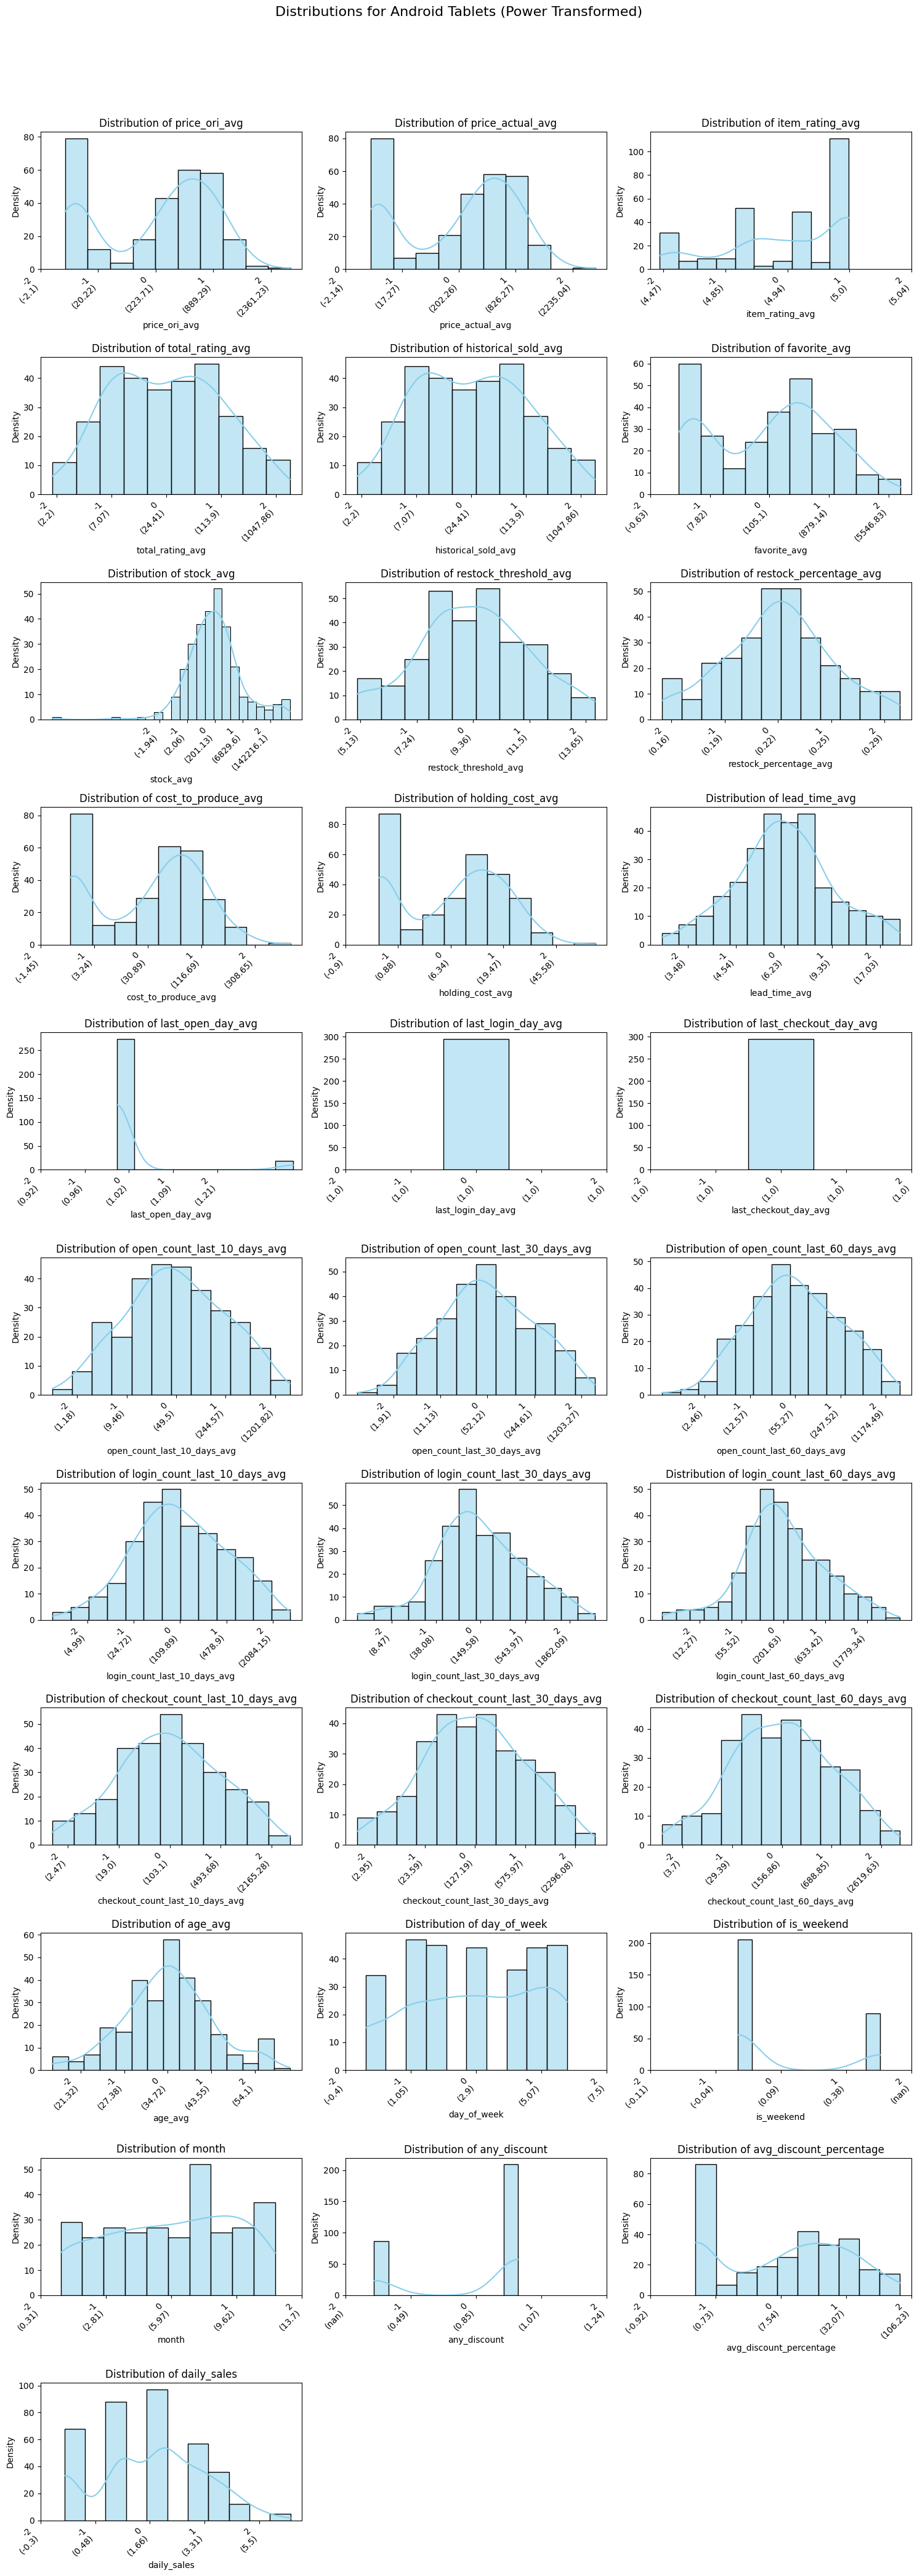


Sub-Category: Occupational Attire


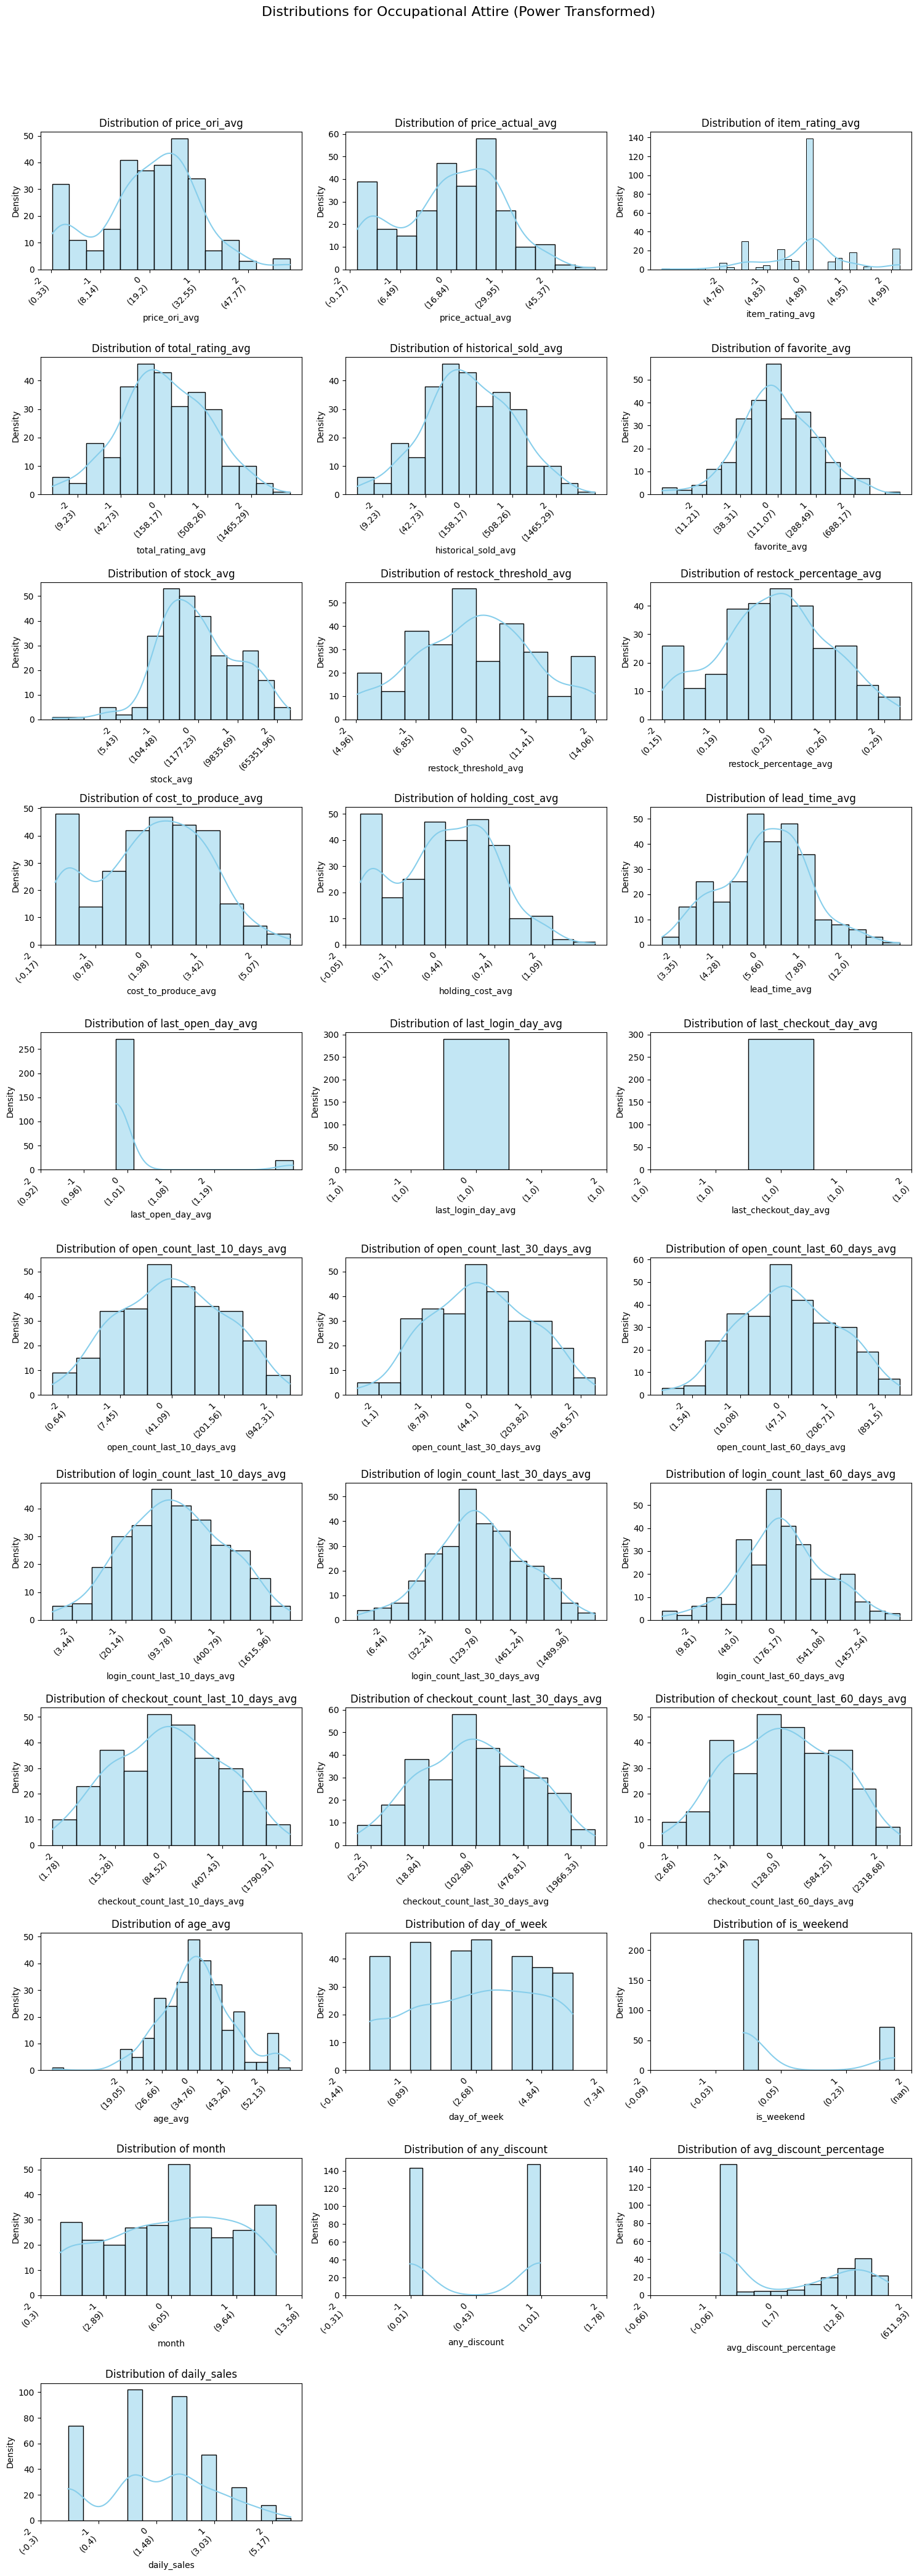


Sub-Category: Business & Casual Shirts


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import warnings  # To suppress warnings

# Suppress warnings for this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Loop over each top sub-category
    for sub_category in top_cats:
        print(f"\nSub-Category: {sub_category}")
        # Filter data for the current sub-category
        sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_category][numeric_columns].copy()
        
        # ----- Power Transformation -----
        pt = PowerTransformer(method='yeo-johnson', standardize=True)
        sub_cat_power_transformed = pd.DataFrame(pt.fit_transform(sub_cat_df), columns=numeric_columns)
        
        # Determine inverse-transformed values for reference points
        transformed_ticks = [-2, -1, 0, 1, 2]
        original_tick_labels = {}

        for col in numeric_columns:
            # Apply inverse transformation for each tick
            inverse_transformed_values = pt.inverse_transform(
                np.array(transformed_ticks).reshape(-1, 1) * np.ones((1, len(numeric_columns)))
            )[:, numeric_columns.index(col)]
            original_tick_labels[col] = {t: round(val, 2) for t, val in zip(transformed_ticks, inverse_transformed_values)}

        # Plot distributions for power-transformed data with custom ticks
        num_cols = 3
        num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
        axes = axes.flatten()  # Flatten axes for easy indexing
        fig.suptitle(f"Distributions for {sub_category} (Power Transformed)", fontsize=16)
        
        for i, col in enumerate(numeric_columns):
            sns.histplot(sub_cat_power_transformed[col], kde=True, ax=axes[i], color='skyblue')
            axes[i].set_title(f"Distribution of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Density")
            
            # Set custom x-ticks for both transformed and original values
            axes[i].set_xticks(transformed_ticks)
            axes[i].set_xticklabels(
                [f"{t}\n({original_tick_labels[col][t]})" for t in transformed_ticks],
                rotation=45, ha='right'
            )
        
        # Remove any unused axes
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



Sub-Category: Android Tablets


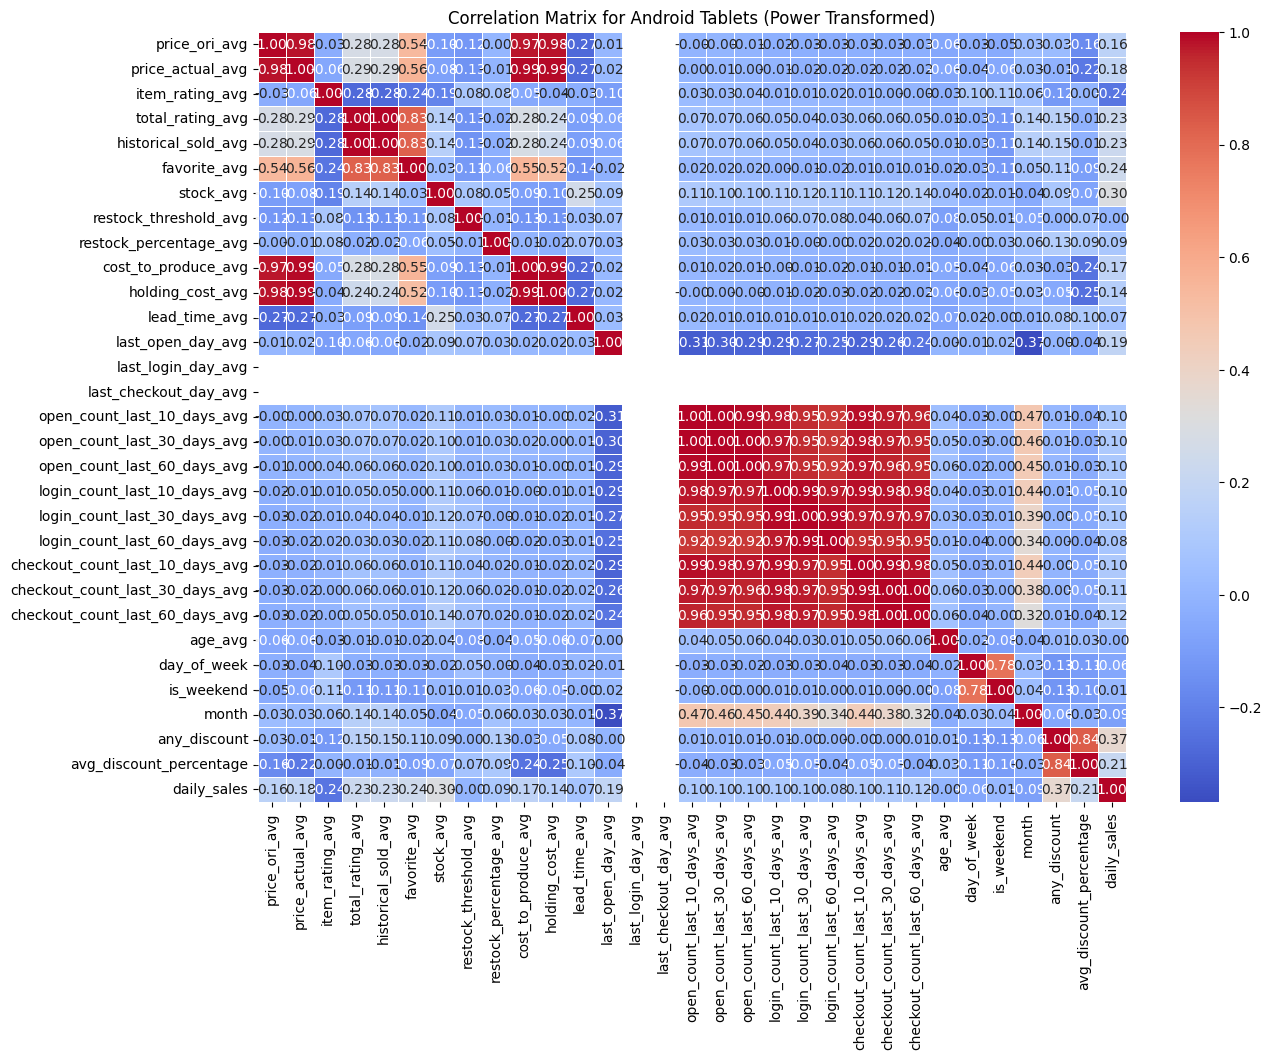


Sub-Category: Occupational Attire


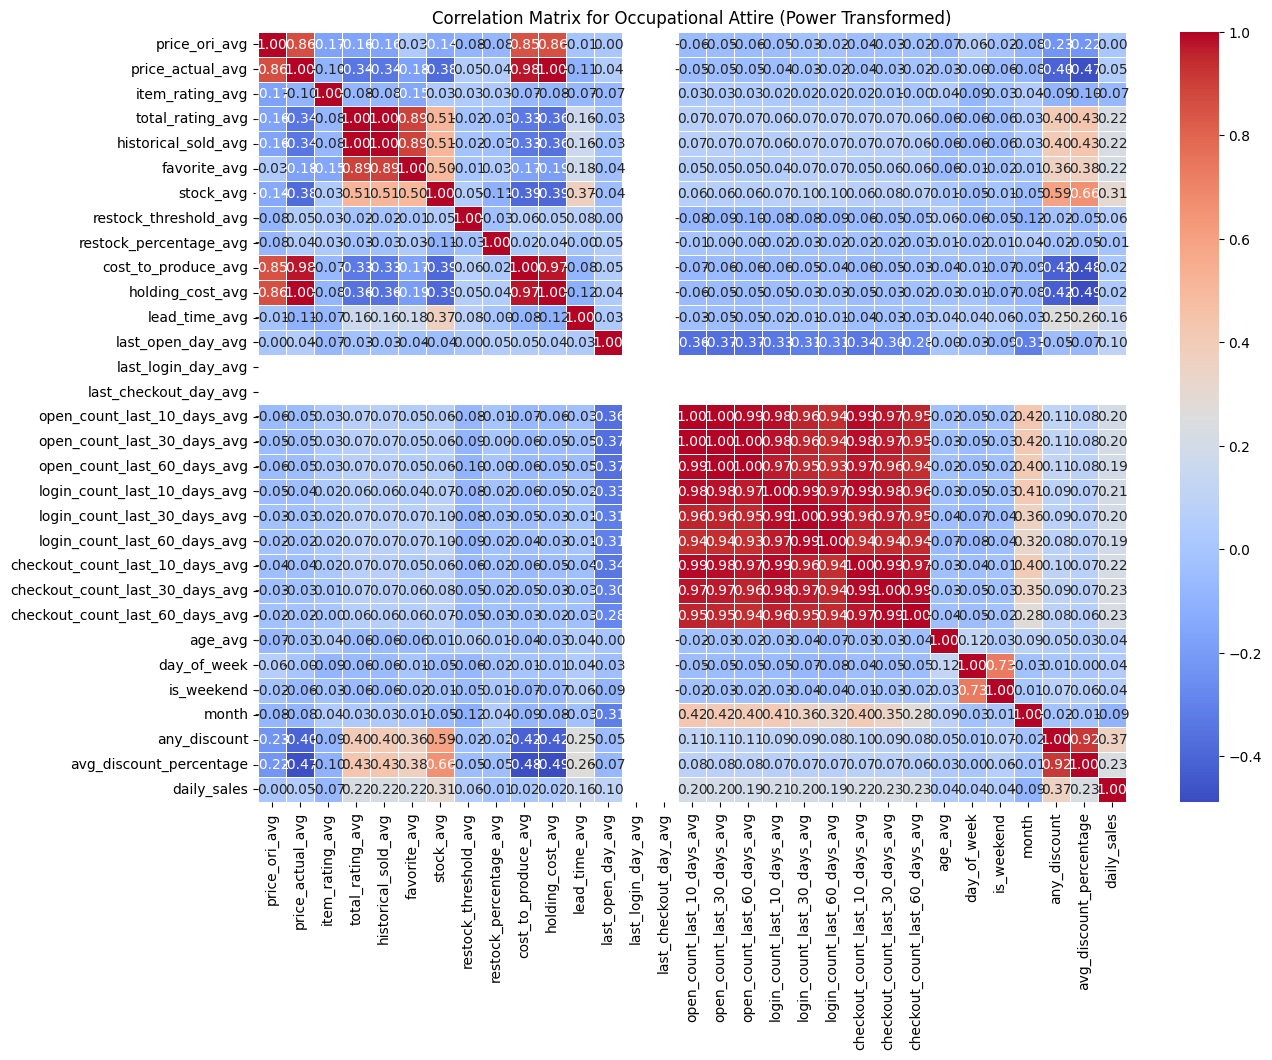


Sub-Category: Business & Casual Shirts


BracketError: The algorithm terminated without finding a valid bracket. Consider trying different initial points.

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# Loop over each top sub-category
for sub_category in top_cats:
    print(f"\nSub-Category: {sub_category}")
    # Filter data for the current sub-category
    sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_category][numeric_columns].copy()
    
    # Apply Power Transformation
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    sub_cat_power_transformed = pd.DataFrame(pt.fit_transform(sub_cat_df), columns=numeric_columns)
    
    # Power-transformed correlation matrix
    power_corr_matrix = sub_cat_power_transformed.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(power_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Matrix for {sub_category} (Power Transformed)")
    plt.show()



Sub-Category: Android Tablets


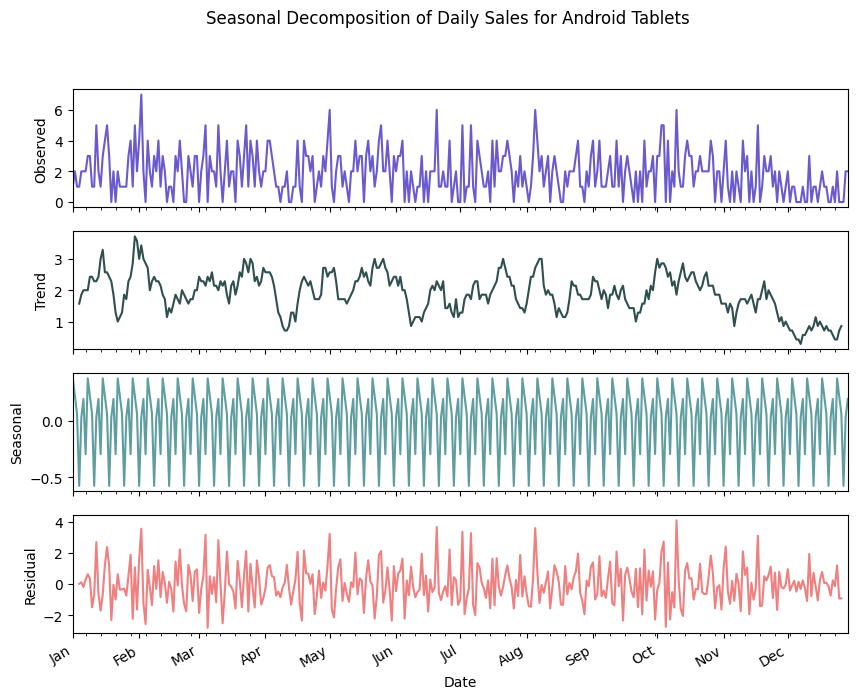

ADF Statistic: -18.12
p-value: 0.00
Critical Value 1%: -3.449
Critical Value 5%: -2.870
Critical Value 10%: -2.571
The series is stationary.

Sub-Category: Occupational Attire


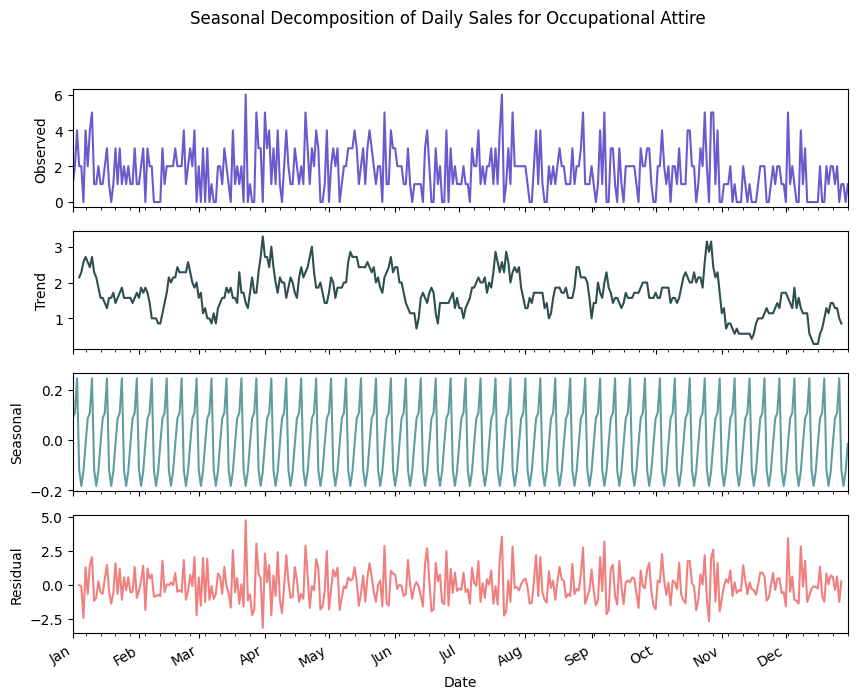

ADF Statistic: -5.95
p-value: 0.00
Critical Value 1%: -3.449
Critical Value 5%: -2.870
Critical Value 10%: -2.571
The series is stationary.

Sub-Category: Business & Casual Shirts


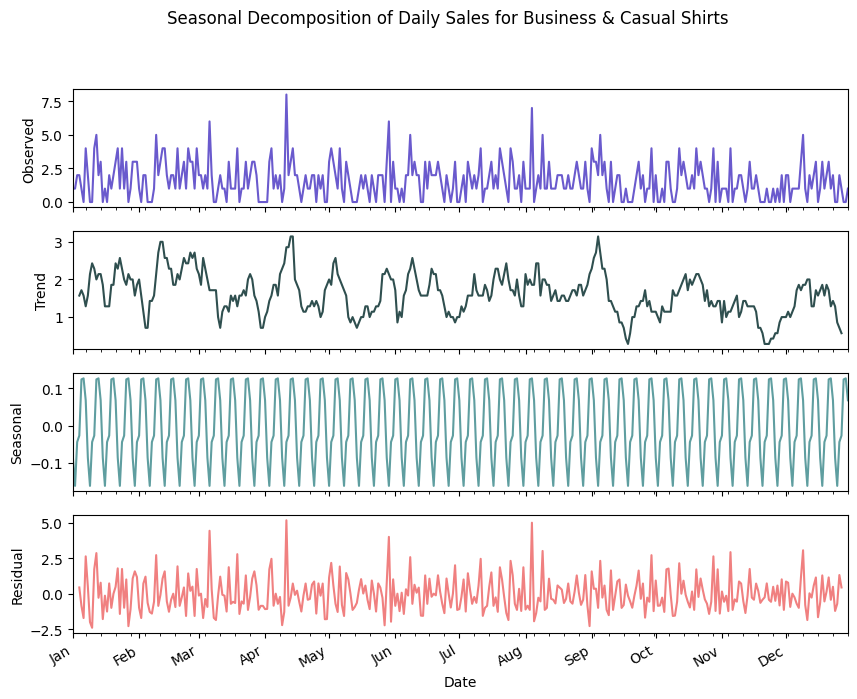

ADF Statistic: -17.95
p-value: 0.00
Critical Value 1%: -3.448
Critical Value 5%: -2.870
Critical Value 10%: -2.571
The series is stationary.


In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates

# Time Series Analysis on Daily Aggregated Data
for sub_category in top_cats:
    print(f"\nSub-Category: {sub_category}")
    
    # Filter data for the current sub-category and set order_time as the index
    sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_category].copy()
    sub_cat_df.set_index('order_time', inplace=True)
    
    # ----- 1. Seasonal Decomposition -----
    # Decomposing daily sales time series
    decomposed = seasonal_decompose(sub_cat_df['daily_sales'], model='additive', period=7)
    
    # Plot decomposition results with custom x-axis for months
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    decomposed.observed.plot(ax=ax1, legend=False, color='slateblue')
    ax1.set_ylabel("Observed")
    decomposed.trend.plot(ax=ax2, legend=False, color='darkslategray')
    ax2.set_ylabel("Trend")
    decomposed.seasonal.plot(ax=ax3, legend=False, color='cadetblue')
    ax3.set_ylabel("Seasonal")
    decomposed.resid.plot(ax=ax4, legend=False, color='lightcoral')
    ax4.set_ylabel("Residual")

    # Set x-axis to display months only
    ax4.set_xlabel("Date")
    ax4.xaxis.set_major_locator(mdates.MonthLocator())  # Place ticks at the start of each month
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as abbreviated month only
    fig.autofmt_xdate()  # Rotate date labels for better readability

    plt.suptitle(f"Seasonal Decomposition of Daily Sales for {sub_category}")
    plt.show()
    
    # ----- 2. Stationarity Test -----
    # Perform Augmented Dickey-Fuller test on daily sales
    adf_result = adfuller(sub_cat_df['daily_sales'].dropna())
    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.2f}")
    for key, value in adf_result[4].items():
        print(f'Critical Value {key}: {value:.3f}')
    if adf_result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")



Sub-Category: Android Tablets


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_3144\4229473006.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)


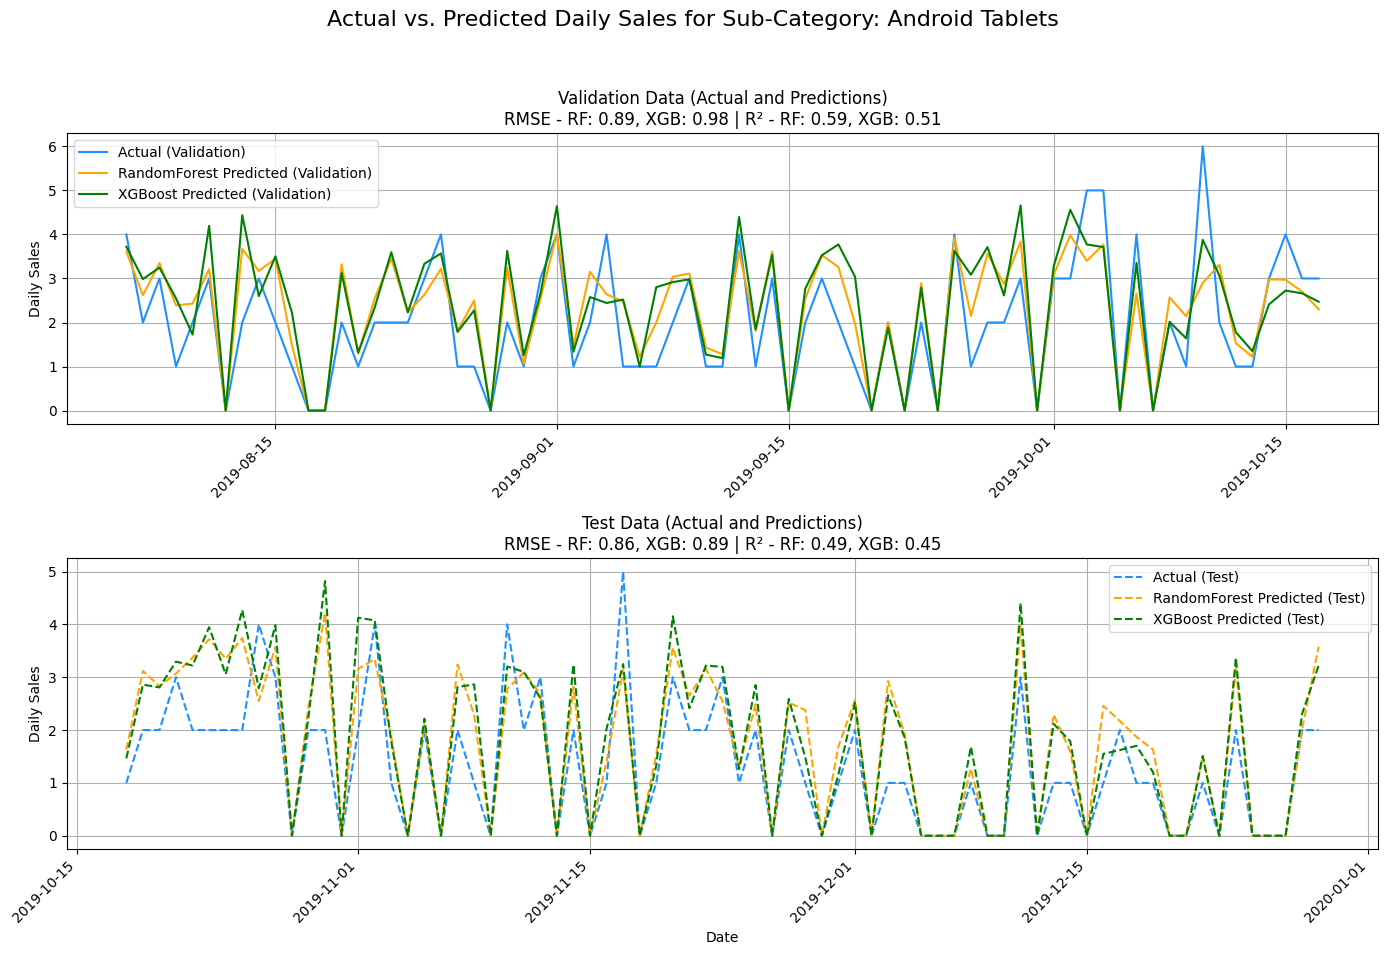


Sub-Category: Occupational Attire


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_3144\4229473006.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)


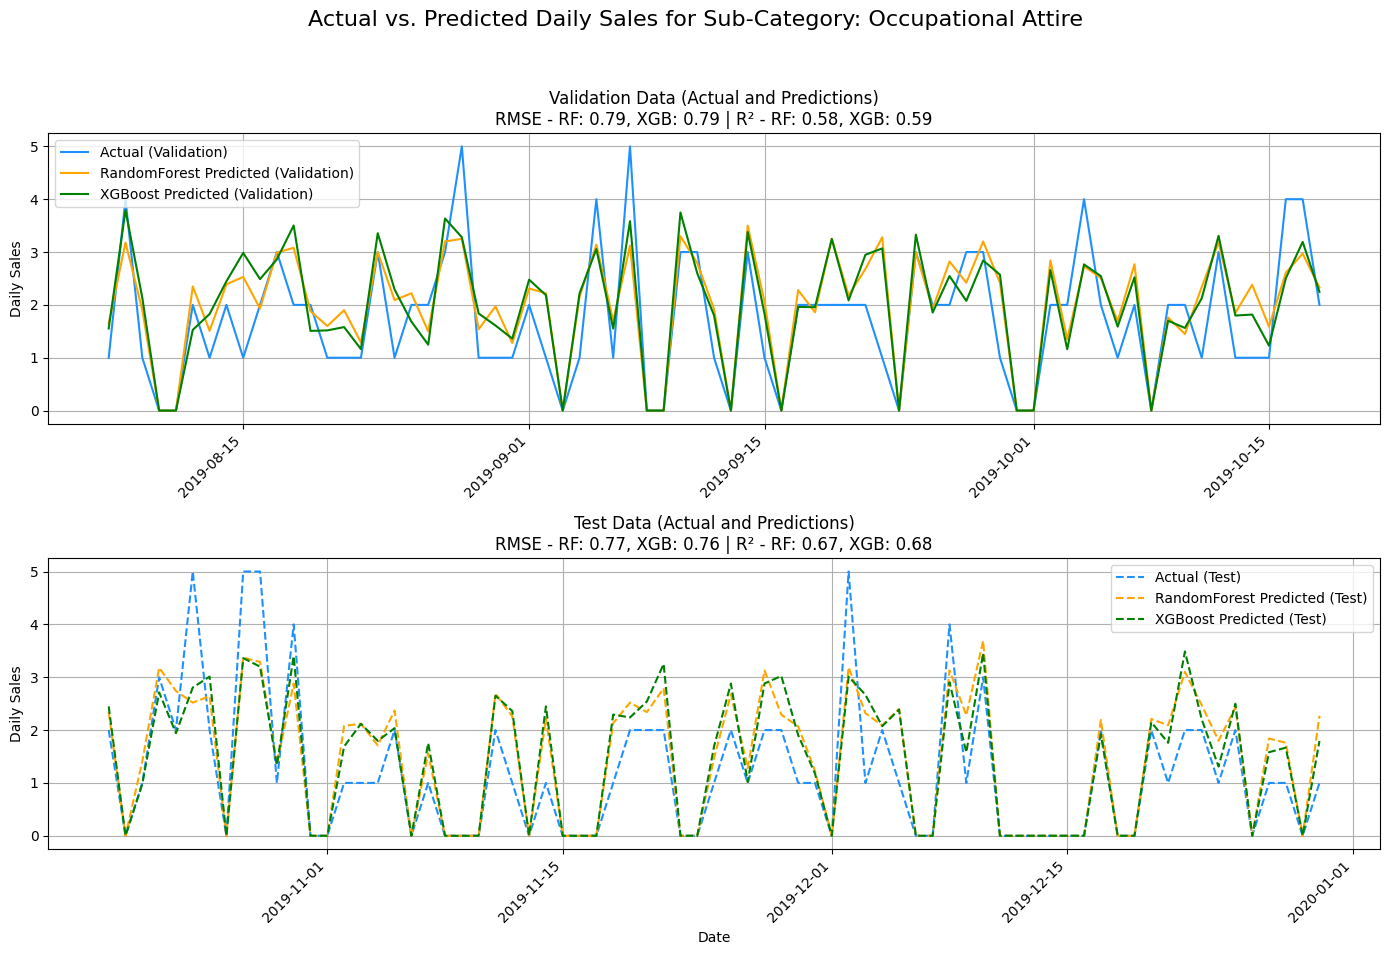


Sub-Category: Business & Casual Shirts


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_3144\4229473006.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)


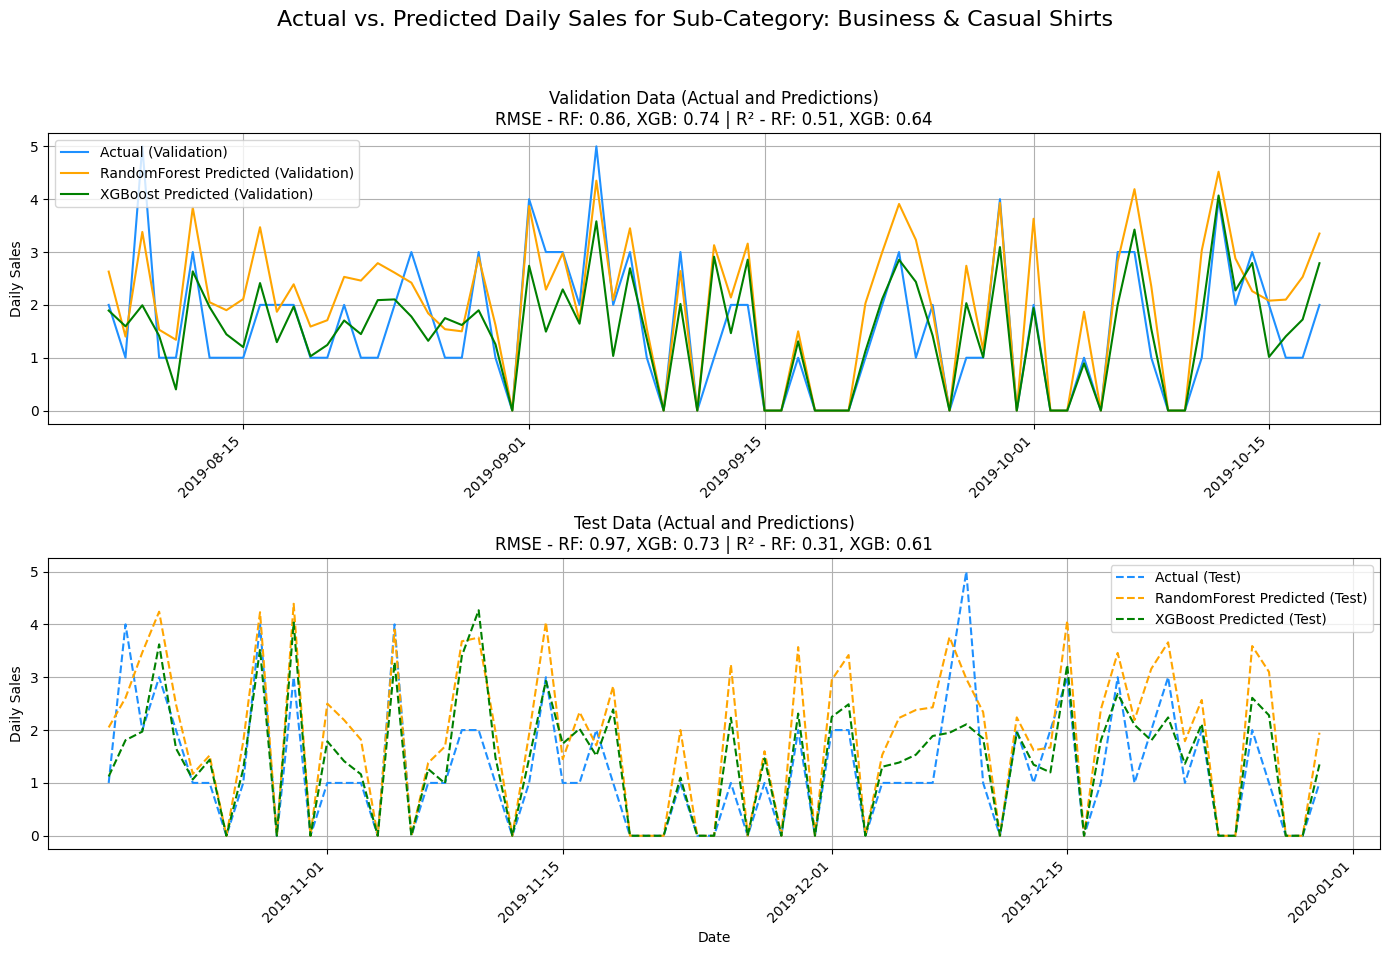

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define the features to use
features = numeric_columns.copy()
features.remove('daily_sales')

# Loop through each top sub-category
for sub_category in top_cats:
    print(f"\nSub-Category: {sub_category}")
    # Filter data for the current sub-category and limit to January-October data
    sub_cat_df = daily_aggregated_df[(daily_aggregated_df['sub_category'] == sub_category) & 
                                     (daily_aggregated_df['order_time'] < '2024-11-01')]
    
    # Define the features and target, and add 'order_time' for date-based indexing
    X = sub_cat_df[features]
    y = sub_cat_df['daily_sales']
    order_time = sub_cat_df['order_time']  # Keep the 'order_time' for plotting
    
    # Ensure 'any_discount' is boolean
    X['any_discount'] = X['any_discount'].astype(bool)
    
    # Split data into training, validation, and test sets based on `order_time`
    X_train_full, X_test, y_train_full, y_test, train_time_full, test_time = train_test_split(
        X, y, order_time, test_size=0.2, shuffle=False)
    X_train, X_valid, y_train, y_valid, train_time, valid_time = train_test_split(
        X_train_full, y_train_full, train_time_full, test_size=0.25, shuffle=False)  # 60% train, 20% valid, 20% test

    # Define models
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=0),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
    }

    # Store predictions and metrics for each model
    predictions = {}
    metrics = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        # Predictions for validation and test
        y_valid_pred = model.predict(X_valid)
        y_test_pred = model.predict(X_test)
        predictions[name] = (y_valid_pred, y_test_pred)
        
        # Calculate metrics for validation and test
        metrics[name] = {
            'valid': {
                'r2': r2_score(y_valid, y_valid_pred),
                'rmse': np.sqrt(mean_squared_error(y_valid, y_valid_pred))
            },
            'test': {
                'r2': r2_score(y_test, y_test_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
            }
        }

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle(f"Actual vs. Predicted Daily Sales for Sub-Category: {sub_category}", fontsize=16)

    # 1. Validation Data (Actual and Predictions)
    axes[0].plot(valid_time, y_valid, label="Actual (Validation)", color="dodgerblue")
    for name, (y_valid_pred, _) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[0].plot(valid_time, y_valid_pred, label=f"{name} Predicted (Validation)", color=color)
    axes[0].set_title(f"Validation Data (Actual and Predictions)\nRMSE - RF: {metrics['RandomForest']['valid']['rmse']:.2f}, XGB: {metrics['XGBoost']['valid']['rmse']:.2f} | R² - RF: {metrics['RandomForest']['valid']['r2']:.2f}, XGB: {metrics['XGBoost']['valid']['r2']:.2f}")
    axes[0].set_ylabel("Daily Sales")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Test Data (Actual and Predictions)
    axes[1].plot(test_time, y_test, label="Actual (Test)", color="dodgerblue", linestyle="--")
    for name, (_, y_test_pred) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[1].plot(test_time, y_test_pred, label=f"{name} Predicted (Test)", color=color, linestyle="--")
    axes[1].set_title(f"Test Data (Actual and Predictions)\nRMSE - RF: {metrics['RandomForest']['test']['rmse']:.2f}, XGB: {metrics['XGBoost']['test']['rmse']:.2f} | R² - RF: {metrics['RandomForest']['test']['r2']:.2f}, XGB: {metrics['XGBoost']['test']['r2']:.2f}")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Daily Sales")
    axes[1].grid(True)
    axes[1].legend()

    # Format x-axis to show dates as Year-Month-Day
    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Loop through each top sub-category
for sub_category in top_cats:
    print(f"\nSub-Category: {sub_category}")
    # Filter data for the current sub-category and limit to January-October data
    sub_cat_df = daily_aggregated_df[(daily_aggregated_df['sub_category'] == sub_category) & 
                                     (daily_aggregated_df['order_time'] < '2024-11-01')]
    
    # Define the features and target, and add 'order_time' for date-based indexing
    X = sub_cat_df[features]
    y = sub_cat_df['daily_sales']
    order_time = sub_cat_df['order_time']  # Keep the 'order_time' for plotting
    
    # Ensure 'any_discount' is boolean
    X['any_discount'] = X['any_discount'].astype(bool)
    
    # Split data into training, validation, and test sets based on `order_time`
    X_train_full, X_test, y_train_full, y_test, train_time_full, test_time = train_test_split(
        X, y, order_time, test_size=0.2, shuffle=False)
    X_train, X_valid, y_train, y_valid, train_time, valid_time = train_test_split(
        X_train_full, y_train_full, train_time_full, test_size=0.25, shuffle=False)  # 60% train, 20% valid, 20% test

    # Define models
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=0),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
    }

    # Store predictions and metrics for each model
    predictions = {}
    metrics = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        # Predictions for validation and test
        y_valid_pred = model.predict(X_valid)
        y_test_pred = model.predict(X_test)
        predictions[name] = (y_valid_pred, y_test_pred)
        
        # Calculate metrics for validation and test
        metrics[name] = {
            'valid': {
                'r2': r2_score(y_valid, y_valid_pred),
                'rmse': np.sqrt(mean_squared_error(y_valid, y_valid_pred))
            },
            'test': {
                'r2': r2_score(y_test, y_test_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
            }
        }

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle(f"Actual vs. Predicted Daily Sales for Sub-Category: {sub_category}", fontsize=16)

    # 1. Validation Data (Actual and Predictions)
    axes[0].plot(valid_time, y_valid, label="Actual (Validation)", color="dodgerblue")
    for name, (y_valid_pred, _) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[0].plot(valid_time, y_valid_pred, label=f"{name} Predicted (Validation)", color=color)
    axes[0].set_title(f"Validation Data (Actual and Predictions)\nRMSE - RF: {metrics['RandomForest']['valid']['rmse']:.2f}, XGB: {metrics['XGBoost']['valid']['rmse']:.2f} | R² - RF: {metrics['RandomForest']['valid']['r2']:.2f}, XGB: {metrics['XGBoost']['valid']['r2']:.2f}")
    axes[0].set_ylabel("Daily Sales")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Test Data (Actual and Predictions)
    axes[1].plot(test_time, y_test, label="Actual (Test)", color="dodgerblue", linestyle="--")
    for name, (_, y_test_pred) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[1].plot(test_time, y_test_pred, label=f"{name} Predicted (Test)", color=color, linestyle="--")
    axes[1].set_title(f"Test Data (Actual and Predictions)\nRMSE - RF: {metrics['RandomForest']['test']['rmse']:.2f}, XGB: {metrics['XGBoost']['test']['rmse']:.2f} | R² - RF: {metrics['RandomForest']['test']['r2']:.2f}, XGB: {metrics['XGBoost']['test']['r2']:.2f}")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Daily Sales")
    axes[1].grid(True)
    axes[1].legend()

    # Format x-axis to show dates as Year-Month-Day
    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



Sub-Category: Android Tablets


KeyError: "['price_avg', 'avg_days_since_last_open', 'avg_days_since_last_login', 'avg_days_since_last_checkout', 'open_ratio_10_days_avg', 'login_ratio_10_days_avg', 'checkout_ratio_10_days_avg'] not in index"

In [ ]:
!{sys.executable} -m pip install optuna

c:\Users\fauza\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\fauza\AppData\Local\Temp\ipykernel_20372\4023677943.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)
[I 2024-10-28 19:33:10,474] A new study created in memory with name: no-name-97e49459-c8b6-4250-b575-e54e26519fa8



Sub-Category: Android Tablets


[I 2024-10-28 19:33:10,722] Trial 0 finished with value: 1.7103124494409974 and parameters: {'n_estimators': 140, 'max_depth': 4, 'learning_rate': 0.047191873824114654, 'subsample': 0.9284127782037461, 'colsample_bytree': 0.6565543894492795, 'gamma': 0.060070344280464816, 'min_child_weight': 8}. Best is trial 0 with value: 1.7103124494409974.
[I 2024-10-28 19:33:10,957] Trial 1 finished with value: 1.6250840082106555 and parameters: {'n_estimators': 155, 'max_depth': 10, 'learning_rate': 0.15628161537061447, 'subsample': 0.9325212874127231, 'colsample_bytree': 0.7316881609213073, 'gamma': 0.01778832283331301, 'min_child_weight': 10}. Best is trial 1 with value: 1.6250840082106555.
[I 2024-10-28 19:33:11,213] Trial 2 finished with value: 1.84053426882278 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.010783766518568175, 'subsample': 0.8193959578317772, 'colsample_bytree': 0.931486620804614, 'gamma': 0.00035718442153476865, 'min_child_weight': 10}. Best is trial

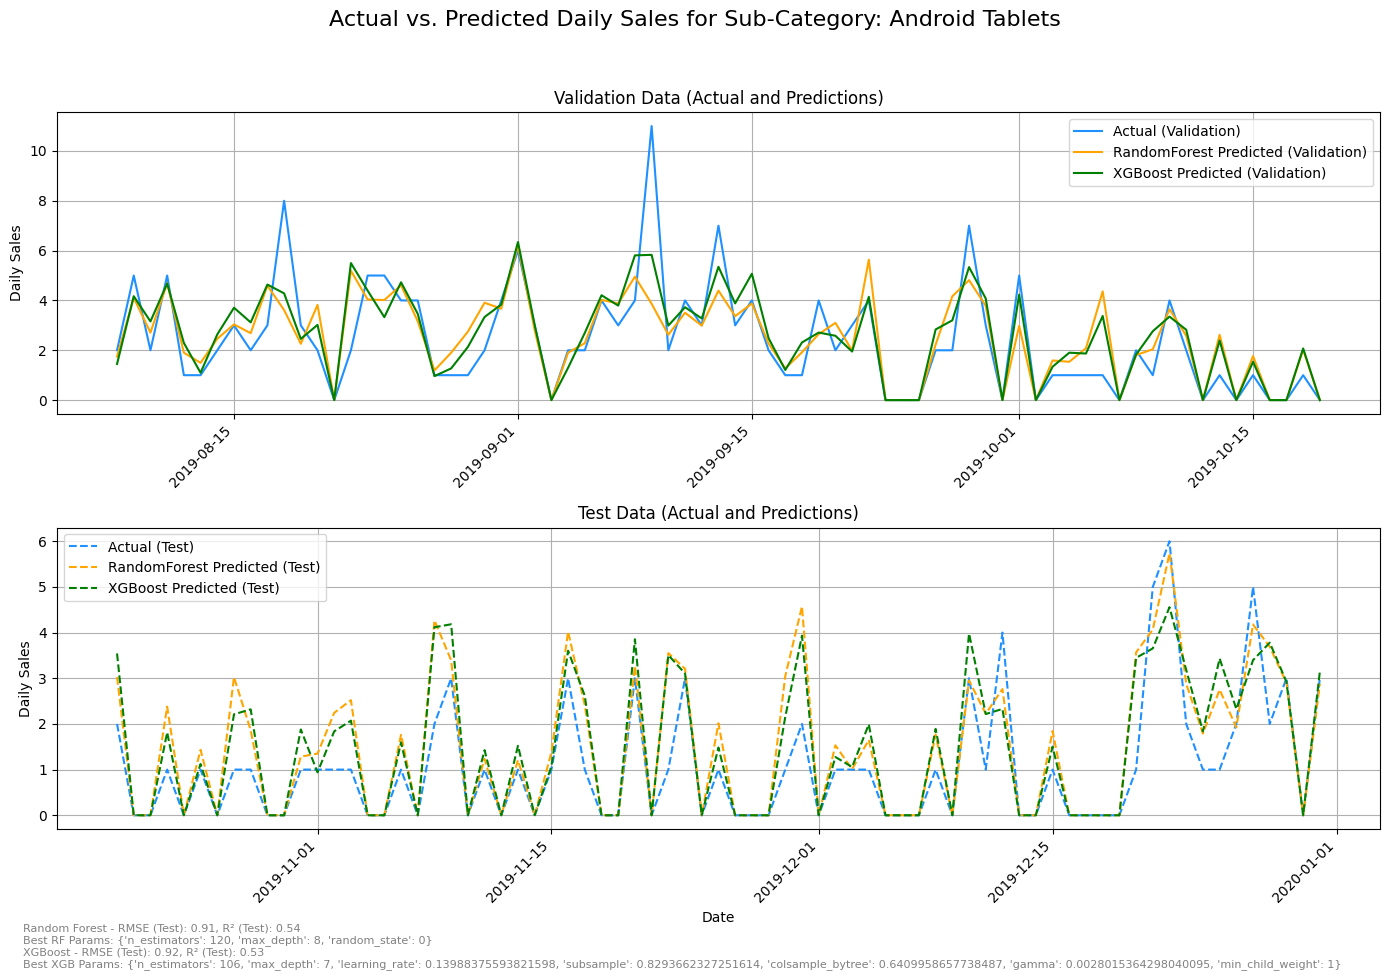

C:\Users\fauza\AppData\Local\Temp\ipykernel_20372\4023677943.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)
[I 2024-10-28 19:33:27,746] A new study created in memory with name: no-name-196554dc-dae7-4a06-a62d-4dc21ae99536



Sub-Category: Occupational Attire


[I 2024-10-28 19:33:27,945] Trial 0 finished with value: 0.7232822100739368 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.11352153222217518, 'subsample': 0.755887560698794, 'colsample_bytree': 0.9443222814473827, 'gamma': 0.022944687188072254, 'min_child_weight': 7}. Best is trial 0 with value: 0.7232822100739368.
[I 2024-10-28 19:33:28,141] Trial 1 finished with value: 0.6723887334226153 and parameters: {'n_estimators': 184, 'max_depth': 3, 'learning_rate': 0.03152339473070233, 'subsample': 0.9397074379857994, 'colsample_bytree': 0.7096368471759829, 'gamma': 0.00043165695887575174, 'min_child_weight': 1}. Best is trial 1 with value: 0.6723887334226153.
[I 2024-10-28 19:33:28,384] Trial 2 finished with value: 0.6873150447269339 and parameters: {'n_estimators': 129, 'max_depth': 10, 'learning_rate': 0.17606074742952707, 'subsample': 0.918633079211596, 'colsample_bytree': 0.7767124554125058, 'gamma': 6.543333238681591e-05, 'min_child_weight': 8}. Best is trial 

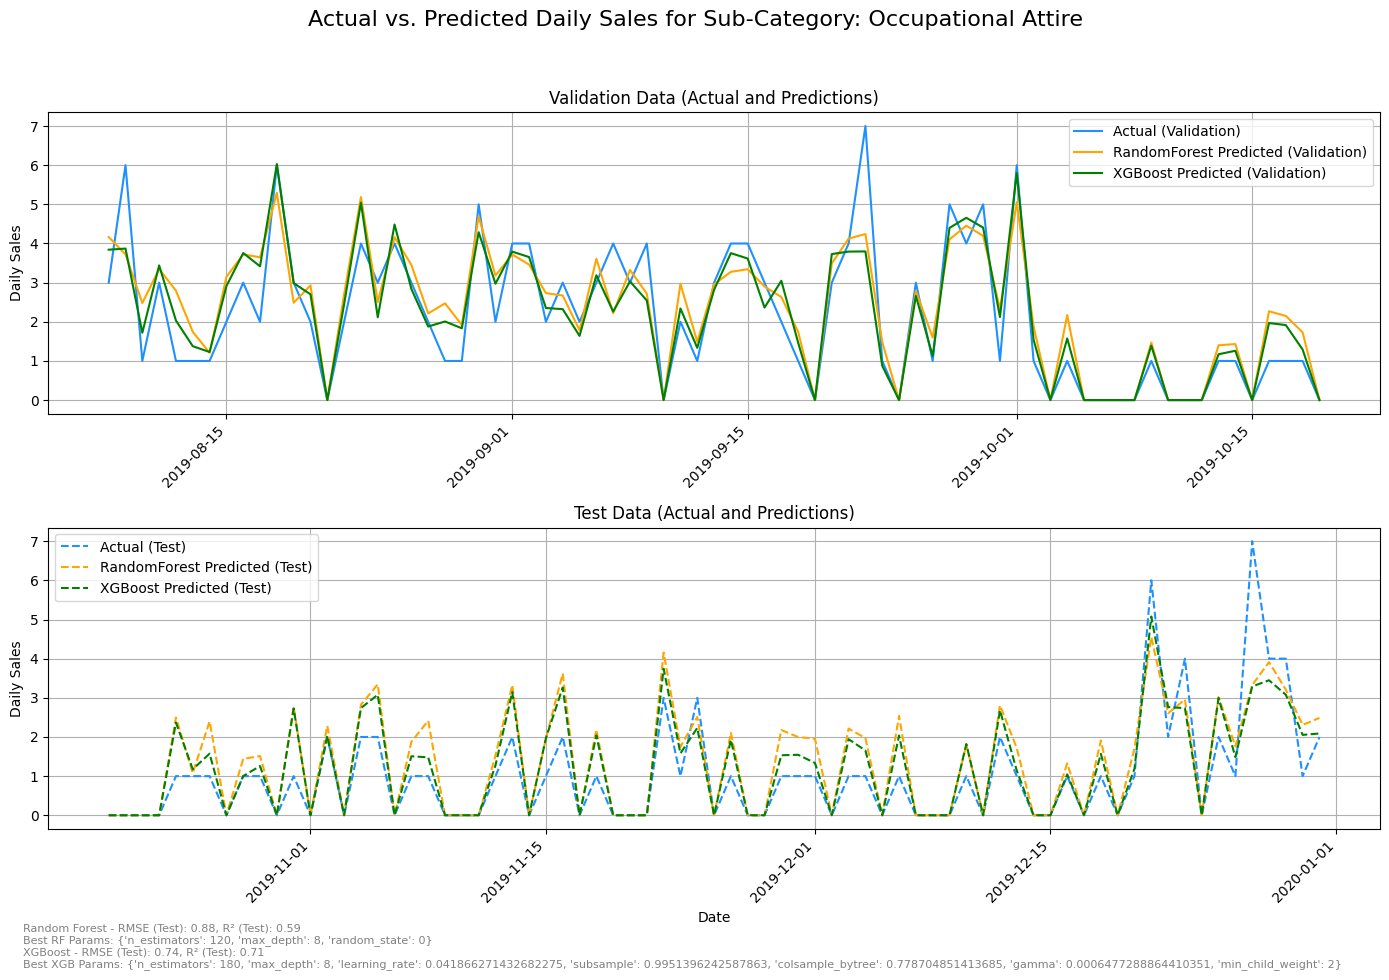

C:\Users\fauza\AppData\Local\Temp\ipykernel_20372\4023677943.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)
[I 2024-10-28 19:33:46,652] A new study created in memory with name: no-name-0006e01a-84a5-422a-9549-290485f5cb57



Sub-Category: Business & Casual Shirts


[I 2024-10-28 19:33:47,176] Trial 0 finished with value: 0.9232328503735865 and parameters: {'n_estimators': 159, 'max_depth': 10, 'learning_rate': 0.015173067379520946, 'subsample': 0.819750384493333, 'colsample_bytree': 0.6024136232070629, 'gamma': 0.0009638799073512946, 'min_child_weight': 2}. Best is trial 0 with value: 0.9232328503735865.
[I 2024-10-28 19:33:47,374] Trial 1 finished with value: 1.0531410306426965 and parameters: {'n_estimators': 182, 'max_depth': 6, 'learning_rate': 0.1468312054380838, 'subsample': 0.8666900629734423, 'colsample_bytree': 0.9308189733500576, 'gamma': 0.0009208251805784086, 'min_child_weight': 2}. Best is trial 0 with value: 0.9232328503735865.
[I 2024-10-28 19:33:47,569] Trial 2 finished with value: 0.8643521156929928 and parameters: {'n_estimators': 143, 'max_depth': 6, 'learning_rate': 0.05425155960192048, 'subsample': 0.8101729751403323, 'colsample_bytree': 0.9955235180421516, 'gamma': 0.022668215790681623, 'min_child_weight': 5}. Best is trial 

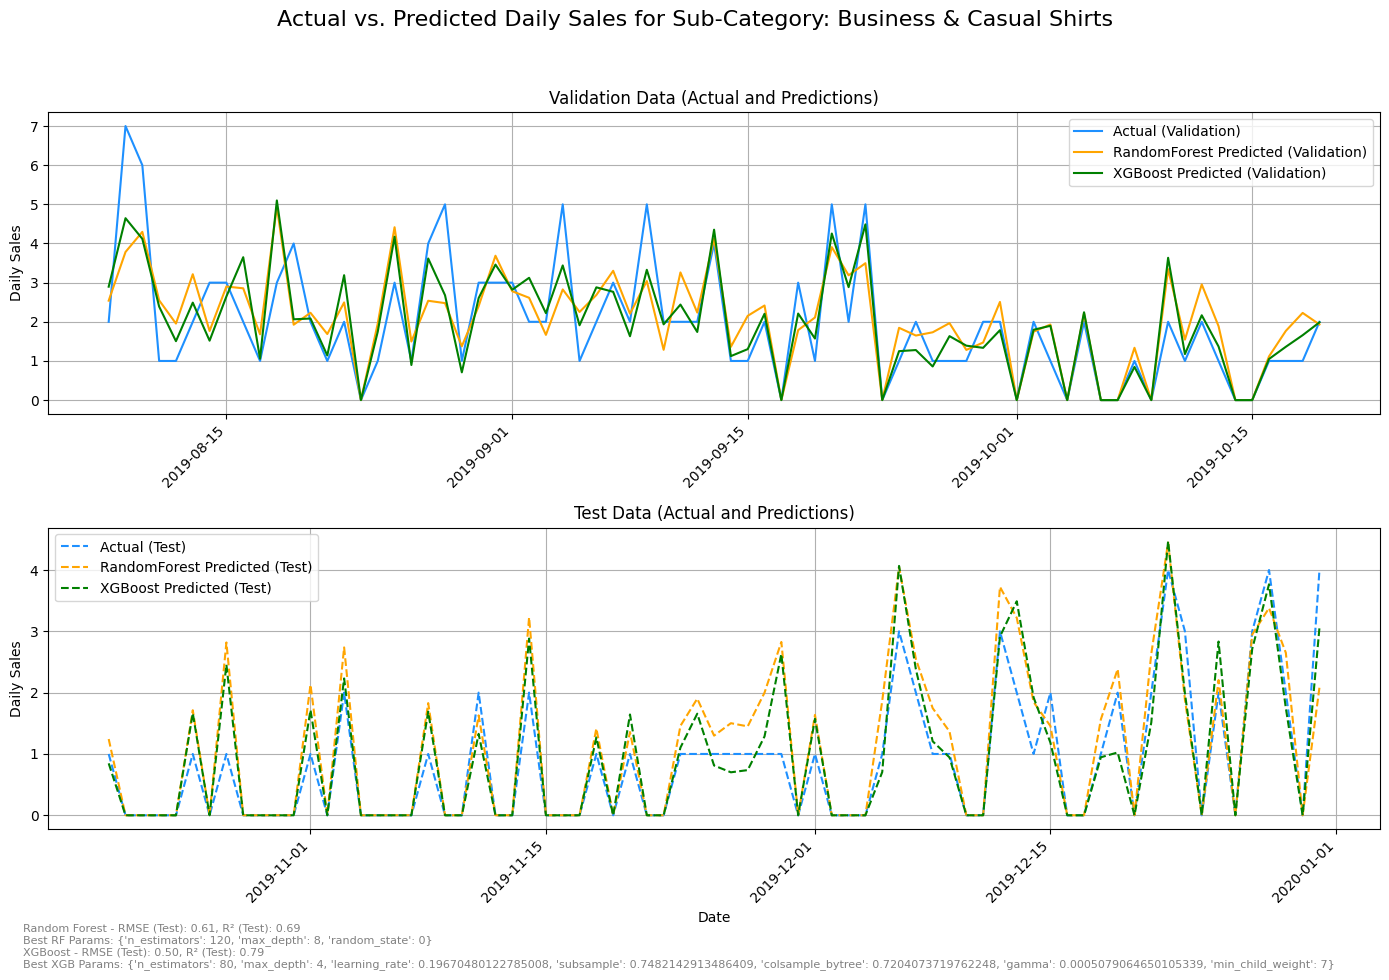

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import optuna

# Function to optimize XGBoost parameters with Optuna
def objective(trial, X_train, y_train, X_valid, y_valid):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e-1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    model = XGBRegressor(**params, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return mean_squared_error(y_valid, y_pred)

# Loop through each top sub-category
for sub_category in top_cats:
    print(f"\nSub-Category: {sub_category}")
    
    # Filter data for the current sub-category and limit to January-October data
    sub_cat_df = daily_aggregated_df[(daily_aggregated_df['sub_category'] == sub_category) & 
                                     (daily_aggregated_df['order_time'] < '2024-11-01')]
    
    # Define the features and target, and add 'order_time' for date-based indexing
    X = sub_cat_df[features]
    y = sub_cat_df['daily_sales']
    order_time = sub_cat_df['order_time']  # Keep the 'order_time' for plotting
    
    # Ensure 'any_discount' is boolean
    X['any_discount'] = X['any_discount'].astype(bool)
    
    # Split data into training, validation, and test sets based on `order_time`
    X_train_full, X_test, y_train_full, y_test, train_time_full, test_time = train_test_split(
        X, y, order_time, test_size=0.2, shuffle=False)
    X_train, X_valid, y_train, y_valid, train_time, valid_time = train_test_split(
        X_train_full, y_train_full, train_time_full, test_size=0.25, shuffle=False)  # 60% train, 20% valid, 20% test

    # Optimize XGBoost parameters using Optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=50)
    best_xgb_params = study.best_params
    
    # Define models with best hyperparameters from Optuna for XGBoost and predefined RF
    rf_params = {'n_estimators': 120, 'max_depth': 8, 'random_state': 0}
    models = {
        'RandomForest': RandomForestRegressor(**rf_params),
        'XGBoost': XGBRegressor(**best_xgb_params, random_state=0)
    }

    # Store predictions and metrics for each model
    predictions = {}
    metrics = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        # Predictions for validation and test
        y_valid_pred = model.predict(X_valid)
        y_test_pred = model.predict(X_test)
        predictions[name] = (y_valid_pred, y_test_pred)
        
        # Calculate metrics for validation and test
        metrics[name] = {
            'valid': {
                'r2': r2_score(y_valid, y_valid_pred),
                'rmse': np.sqrt(mean_squared_error(y_valid, y_valid_pred))
            },
            'test': {
                'r2': r2_score(y_test, y_test_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
            }
        }

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle(f"Actual vs. Predicted Daily Sales for Sub-Category: {sub_category}", fontsize=16)

    # 1. Validation Data (Actual and Predictions)
    axes[0].plot(valid_time, y_valid, label="Actual (Validation)", color="dodgerblue")
    for name, (y_valid_pred, _) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[0].plot(valid_time, y_valid_pred, label=f"{name} Predicted (Validation)", color=color)
    axes[0].set_title("Validation Data (Actual and Predictions)")
    axes[0].set_ylabel("Daily Sales")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Test Data (Actual and Predictions)
    axes[1].plot(test_time, y_test, label="Actual (Test)", color="dodgerblue", linestyle="--")
    for name, (_, y_test_pred) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[1].plot(test_time, y_test_pred, label=f"{name} Predicted (Test)", color=color, linestyle="--")
    axes[1].set_title("Test Data (Actual and Predictions)")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Daily Sales")
    axes[1].grid(True)
    axes[1].legend()

    # Add small text with R2, RMSE, and best hyperparameters for both models
    fig.text(
        0.02, 0.02,
        f"Random Forest - RMSE (Test): {metrics['RandomForest']['test']['rmse']:.2f}, R² (Test): {metrics['RandomForest']['test']['r2']:.2f}\n"
        f"Best RF Params: {rf_params}\n"
        f"XGBoost - RMSE (Test): {metrics['XGBoost']['test']['rmse']:.2f}, R² (Test): {metrics['XGBoost']['test']['r2']:.2f}\n"
        f"Best XGB Params: {best_xgb_params}",
        fontsize=8, color='gray', ha='left', va='bottom'
    )

    # Format x-axis to show dates as Year-Month-Day
    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()



Feature Importance for Sub-Category: Android Tablets


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_3144\3251475874.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)


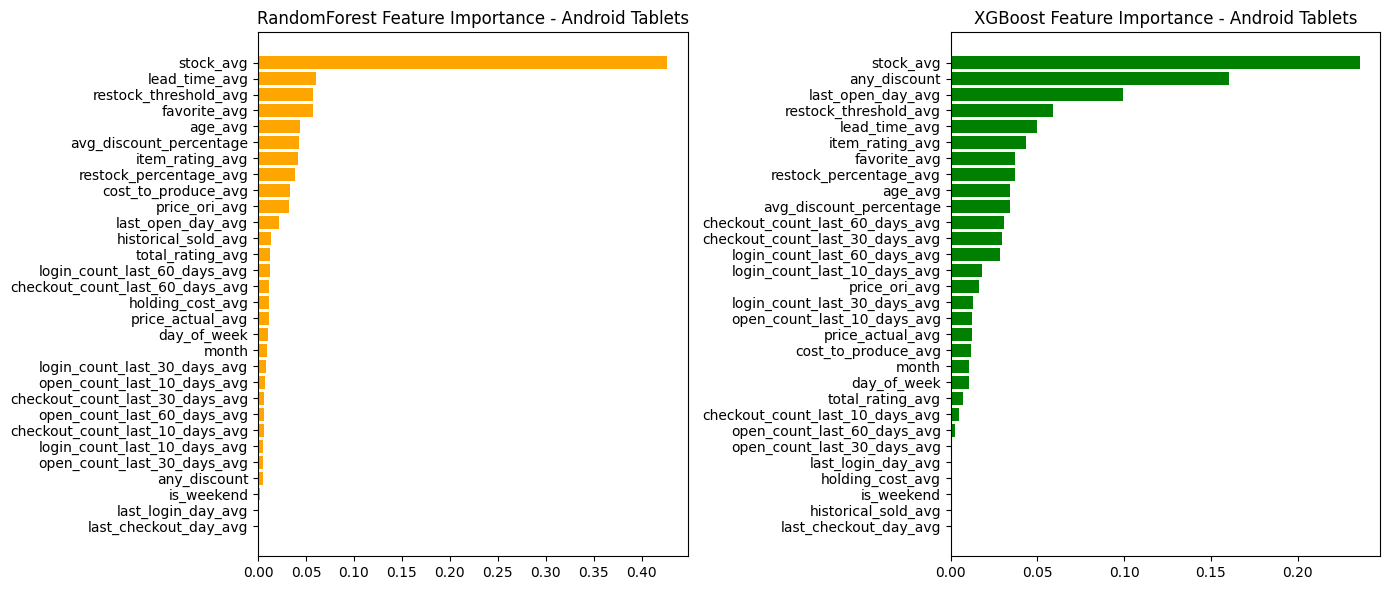


Feature Importance for Sub-Category: Occupational Attire


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_3144\3251475874.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)


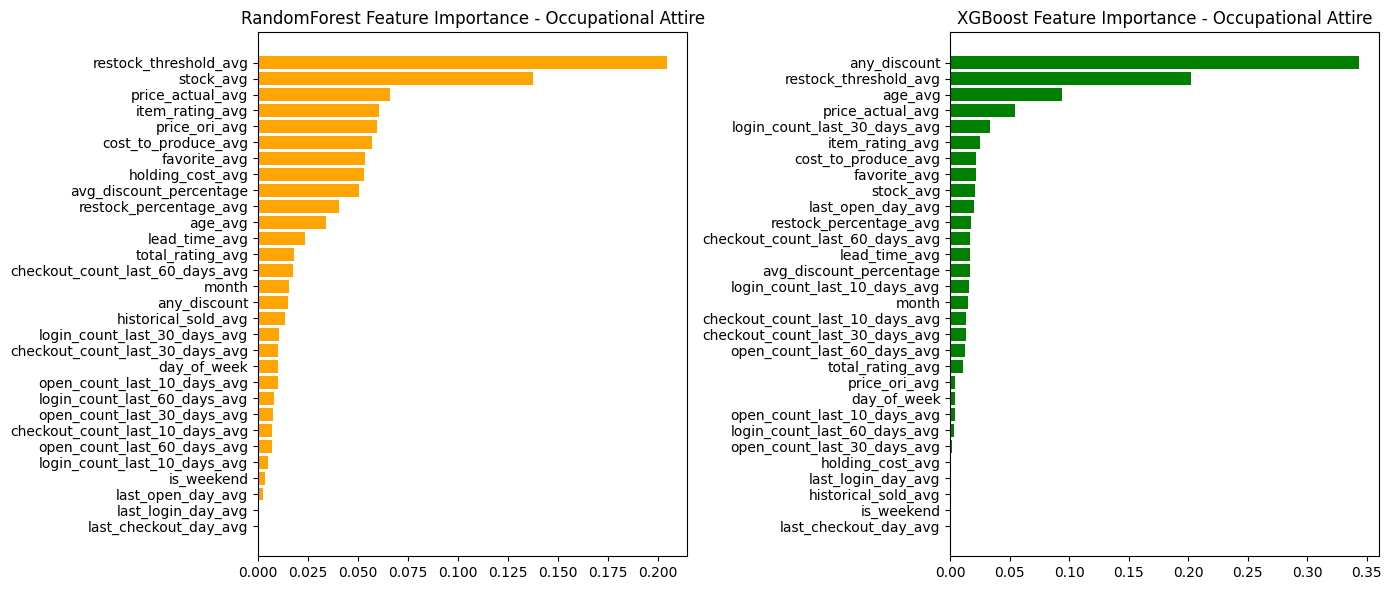


Feature Importance for Sub-Category: Business & Casual Shirts


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_3144\3251475874.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['any_discount'] = X['any_discount'].astype(bool)


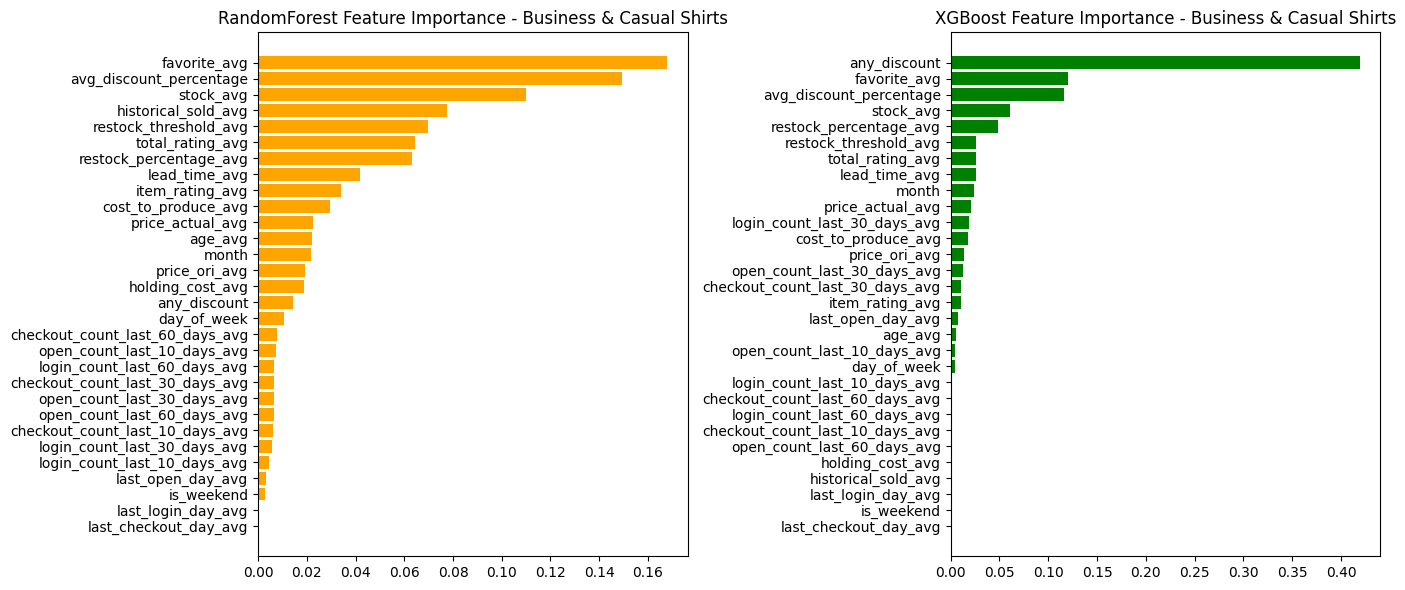

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Iterate over each sub-category
for sub_cat in top_cats:
    print(f"\nFeature Importance for Sub-Category: {sub_cat}")
    
    # Filter data for the current sub-category
    sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_cat]
    
    # Define X and y
    X = sub_cat_df[features]
    y = sub_cat_df['daily_sales']
    
    # Ensure 'any_discount' is boolean
    X['any_discount'] = X['any_discount'].astype(bool)

    # Handle any non-numeric data (e.g., encoding 'ships_most_from' if necessary)
    # X = pd.get_dummies(X, columns=['ships_most_from'])

    # RandomForest Feature Importance
    rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_model.fit(X, y)
    rf_importances = rf_model.feature_importances_

    # XGBoost Feature Importance
    xgb_model = XGBRegressor(n_estimators=100, random_state=0)
    xgb_model.fit(X, y)
    xgb_importances = xgb_model.feature_importances_

    # Plotting Feature Importances
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    rf_sorted_idx = np.argsort(rf_importances)
    xgb_sorted_idx = np.argsort(xgb_importances)

    # RandomForest Feature Importance
    ax[0].barh(range(len(rf_sorted_idx)), rf_importances[rf_sorted_idx], color="orange")
    ax[0].set_yticks(range(len(rf_sorted_idx)))
    ax[0].set_yticklabels(np.array(features)[rf_sorted_idx])
    ax[0].set_title(f"RandomForest Feature Importance - {sub_cat}")

    # XGBoost Feature Importance
    ax[1].barh(range(len(xgb_sorted_idx)), xgb_importances[xgb_sorted_idx], color="green")
    ax[1].set_yticks(range(len(xgb_sorted_idx)))
    ax[1].set_yticklabels(np.array(features)[xgb_sorted_idx])
    ax[1].set_title(f"XGBoost Feature Importance - {sub_cat}")

    plt.tight_layout()
    plt.show()



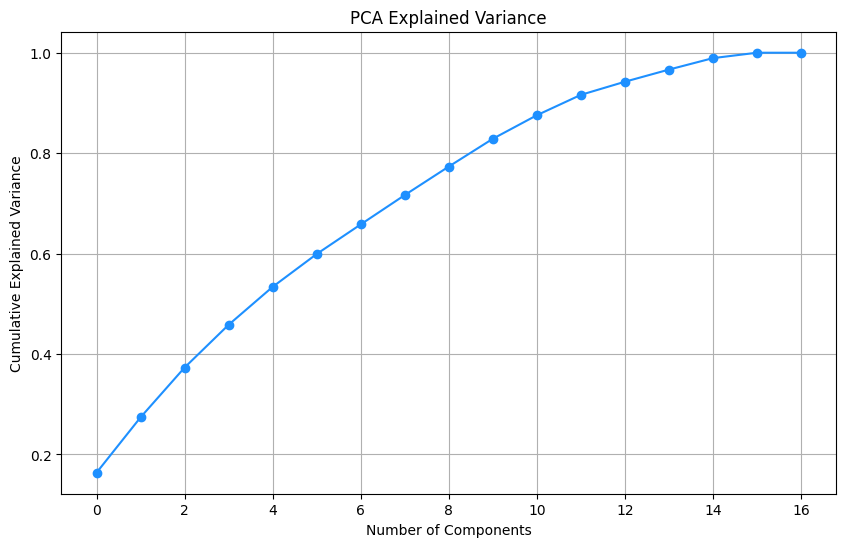

Top contributing features in the first few principal components:
                                   PC1       PC2       PC3       PC4       PC5
price_avg                     0.001338 -0.007288 -0.021672 -0.008281 -0.018434
item_rating_avg              -0.032750  0.020281 -0.014134 -0.177618 -0.354638
total_rating_avg              0.551240  0.108207  0.161670 -0.056594 -0.154851
historical_sold_avg           0.551240  0.108207  0.161670 -0.056594 -0.154851
favorite_avg                  0.490861  0.081261  0.103725 -0.014935 -0.048458
stock_avg                     0.022760 -0.028648 -0.075235 -0.073009  0.006073
avg_days_since_last_open      0.112756 -0.100769 -0.186113  0.009198  0.177704
avg_days_since_last_login     0.107595 -0.423360 -0.044224 -0.013079  0.177892
avg_days_since_last_checkout  0.106147 -0.451961 -0.039337 -0.029222  0.163652
open_ratio_10_days_avg        0.176720 -0.076585 -0.349312 -0.070380  0.299709
login_ratio_10_days_avg      -0.036316  0.529461 -0.202751 -0.0165

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Impute missing values with median
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Standardizing the features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Applying PCA
pca = PCA(n_components=len(features))
X_pca = pca.fit_transform(X_scaled)

# Plotting the Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='dodgerblue')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

# PCA Component Loadings for each feature
pca_loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(len(features))], index=features)

# Display top features in the first few principal components
print("Top contributing features in the first few principal components:")
print(pca_loadings.iloc[:, :5])  # Displaying first 5 principal components for readability


In [ ]:
daily_aggregated_df

sub_category order_time   price_avg  item_rating_avg  \
0               Abdominal Binder 2019-01-02  108.994202             5.00   
1               Abdominal Binder 2019-01-03         NaN              NaN   
2               Abdominal Binder 2019-01-04         NaN              NaN   
3               Abdominal Binder 2019-01-05         NaN              NaN   
4               Abdominal Binder 2019-01-06    0.744275             4.90   
...                          ...        ...         ...              ...   
282996  iPhone Screen Protectors 2019-12-26         NaN              NaN   
282997  iPhone Screen Protectors 2019-12-27    1.220735             4.80   
282998  iPhone Screen Protectors 2019-12-28    2.612747             4.85   
282999  iPhone Screen Protectors 2019-12-29    0.274043             4.80   
283000  iPhone Screen Protectors 2019-12-30    1.058801             4.90   

        total_rating_avg  historical_sold_avg  favorite_avg  stock_avg  \
0                  536.0                536.0         900.0      663.0   
1                    NaN                  NaN           NaN        NaN   
2                    NaN                  NaN           NaN        NaN   
3                    NaN                  NaN           NaN        NaN   
4                  256.0                256.0         134.0    10392.0   
...                  ...                  ...           ...        ...   
282996               NaN                  NaN           NaN        NaN   
282997             224.0                224.0          38.0   478948.0   
282998            6293.5               6293.5        1893.5    95180.0   
282999            9405.0               9405.0        9700.0   203921.0   
283000            1603.0               1603.0         316.0    24668.0   

        avg_days_since_last_open  avg_days_since_last_login  \
0                            8.0                        1.0   
1                            NaN                        NaN   
2                            NaN                        NaN   
3                            NaN                        NaN   
4                           83.0                        1.0   
...                          ...                        ...   
282996                       NaN                        NaN   
282997                      15.0                        1.0   
282998                      19.0                        1.5   
282999                      91.0                        1.0   
283000                      12.0                        1.0   

        avg_days_since_last_checkout  open_ratio_10_days_avg  \
0                                8.0                    0.20   
1                                NaN                     NaN   
2                                NaN                     NaN   
3                                NaN                     NaN   
4                               10.0                    0.00   
...                              ...                     ...   
282996                           NaN                     NaN   
282997                           2.0                    0.00   
282998                           3.5                    0.25   
282999                           4.0                    0.00   
283000                           1.0                    0.00   

        login_ratio_10_days_avg  checkout_ratio_10_days_avg  day_of_week  \
0                      0.183486                    0.190476          2.0   
1                           NaN                         NaN          NaN   
2                           NaN                         NaN          NaN   
3                           NaN                         NaN          NaN   
4                      0.181818                    0.226994          6.0   
...                         ...                         ...          ...   
282996                      NaN                         NaN          NaN   
282997                 0.157658                    0.181818          4.0   
282998  

      main_category Ships_From  price_actual  cost_to_produce  holding_cost  \
0      Women's Bags   Malaysia      4.017215         0.384917      0.122245   
1   Home Appliances      China      0.934236         0.128728      0.028429   
2      Women's Bags   Malaysia      2.647002         0.450066      0.080549   
3     Women Clothes   Malaysia      2.709284         0.237320      0.082444   
4  Cameras & Drones   Malaysia    852.957480       170.276357     25.955787   

   lead_time  
0     6.2200  
1    12.7059  
2     3.5314  
3     3.4624  
4     5.3339  


In [ ]:
products_df.lead_time.value_counts()

lead_time
6.5    390
7.2    379
7.1    376
3.4    375
5.3    372
      ... 
8.3      3
9.5      3
9.9      3
9.8      2
8.8      2
Name: count, Length: 221, dtype: int64

In [ ]:
stop here

Index(['price_ori', 'price_actual', 'title', 'item_rating', 'seller_name',
       'total_rating', 'total_sold', 'favorite', 'desc', 'stock', 'ships_from',
       'product_id', 'main_category', 'mid_category', 'sub_category'],
      dtype='object')

In [ ]:
merged.columns

NameError: name 'merged' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
ORDER_COST = 50          # Cost per order
HOLD_COST = 0.2          # Holding cost per unit per day
LEAD_TIME = 7            # Lead time in days

# Assume daily_aggregated_df has 'daily_sales' as the average sales per day by product
# Calculate the average daily demand by product ID
average_daily_sales = daily_aggregated_df.groupby('sub_category')['daily_sales'].mean().reset_index()
average_daily_sales.rename(columns={'daily_sales': 'daily_demand'}, inplace=True)

# Merge daily demand into products_df
products_df = products_df.merge(average_daily_sales, on='product_id', how='left')

# Fill missing daily demand values if any with a reasonable default (e.g., 1)
products_df['daily_demand'].fillna(1, inplace=True)

# Calculate EOQ and ROP
products_df['EOQ'] = np.sqrt((2 * products_df['daily_demand'] * ORDER_COST) / HOLD_COST)
products_df['ROP'] = products_df['daily_demand'] * LEAD_TIME

# Display EOQ and ROP values
print("EOQ and ROP values for inventory optimization:")
print(products_df[['product_id', 'daily_demand', 'EOQ', 'ROP']])

# Simulation of Inventory Levels
products_df['inventory_level'] = products_df['Stock']  # Starting stock level
products_df['stockouts'] = 0
products_df['orders'] = 0

# Simulate over 30 days
DAYS_TO_SIMULATE = 30
for day in range(DAYS_TO_SIMULATE):
    for i, row in products_df.iterrows():
        demand_today = row['daily_demand']
        
        # Check if an order is needed
        if row['inventory_level'] <= row['ROP']:
            products_df.at[i, 'orders'] += 1
            products_df.at[i, 'inventory_level'] += row['EOQ']  # Replenish stock with EOQ quantity

        # Update inventory level
        if products_df.at[i, 'inventory_level'] >= demand_today:
            products_df.at[i, 'inventory_level'] -= demand_today
        else:
            # Record stockout if demand can't be met
            products_df.at[i, 'stockouts'] += 1

# Display simulation results
print("Simulation results over 30 days:")
print(products_df[['product_id', 'daily_demand', 'inventory_level', 'orders', 'stockouts']])

# Plotting Orders and Stockouts by Product ID
plt.figure(figsize=(12, 6))
plt.plot(products_df['product_id'], products_df['orders'], label="Total Orders", color="orange")
plt.plot(products_df['product_id'], products_df['stockouts'], label="Total Stockouts", color="red")
plt.xlabel("Product ID")
plt.ylabel("Count")
plt.title("Inventory Simulation Results: Orders and Stockouts by Product")
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'product_id'

In [ ]:
import pandas as pd

customers_df = pd.read_csv('../Cleaned_Datasets/customer_SG_only.csv')

customers_df.columns

Index(['Unnamed: 0', 'customer_id', 'subject_line_length', 'last_open_day',
       'last_login_day', 'last_checkout_day', 'open_count_last_10_days',
       'open_count_last_30_days', 'open_count_last_60_days',
       'login_count_last_10_days', 'login_count_last_30_days',
       'login_count_last_60_days', 'checkout_count_last_10_days',
       'checkout_count_last_30_days', 'checkout_count_last_60_days',
       'open_flag', 'row_id', 'attr_1', 'attr_2', 'attr_3', 'age', 'domain',
       'checkout_count_last_1_year'],
      dtype='object')